# LTFS Fin Hack 3

<img src="logo.png" alt="Logo">

## Problem Statement

As a Financial Institution LTFS wants to predict which customers will avail Top Up loans on their existing loans and at what point during their Loan Tenures will they do so. This is a Multi Class classification Problem with the following available class labels:-  
* 12-18 Months
* 18-24 Months
* 24-30 Months
* 30-36 Months
* 36-48 Months
* '>48 Months  

Following Datasets are available for the task:- 

1.**Customer’s Demographics**: The demography table along with the target variable & demographic information contains variables related to Frequency of the loan, Tenure of the loan, Disbursal Amount for a loan & LTV.  

2.**Bureau data**:  Bureau data contains the behavioural and transactional attributes of the customers like current balance, Loan Amount, Overdue etc. for various tradelines of a given customer  

Based on intuition a combination of Demographic and Loan features are likely to be the most important predictors for the task such as Current Amount remaining, Customers total Loan Amounts outstanding, Customer Income etc. 

### Initial Data Exploration

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import lightgbm as lgb

# Custom Imports
from Generate_Bureau_feats import * 
pd.set_option('chained_assignment',None)
%matplotlib inline
%load_ext autoreload

In [2]:
# Ingest the datasets- One time only
# train_data = pd.read_excel("../Data/Train/train_Data.xlsx")
# test_data = pd.read_excel("../Data/Test/test_Data.xlsx")
# train_bureau = pd.read_excel("../Data/Train/train_bureau.xlsx")
# test_bureau = pd.read_excel("../Data/Test/test_bureau.xlsx")

# Pickle datasets for faster reads in future 
# train_pickle = open("../Data/Train/train.pkl", 'wb')
# pickle.dump(train_data, train_pickle)
# train_pickle.close()
# train_bureau_pickle = open("../Data/Train/train_bureau.pkl", 'wb')
# pickle.dump(train_bureau, train_bureau_pickle)
# train_bureau_pickle.close()
# test_pickle = open("../Data/Test/test.pkl", 'wb')
# pickle.dump(test_data, test_pickle)
# test_pickle.close()
# test_bureau_pickle = open("../Data/Test/test_bureau.pkl", 'wb')
# pickle.dump(test_bureau, test_bureau_pickle)
# test_bureau_pickle.close()

In [3]:
# Load from pickle
train_data = pd.read_pickle("../Data/Train/train.pkl")
test_data = pd.read_pickle("../Data/Test/test.pkl")
train_bureau = pd.read_pickle("../Data/Train/train_bureau.pkl")
test_bureau = pd.read_pickle("../Data/Test/test_bureau.pkl")

In [4]:
# Inspect the data
train_data.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,...,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,...,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,...,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,...,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,...,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months


In [5]:
train_bureau.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,...,NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,...,F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,...,NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,...,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,...,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN


In [6]:
# There's a lot of categorical variables in both the datasets. Depending on number of Unique values we might need to club or drop 
# some vars. Let's see levels for categorical variables in both demographic and bureau data
cat_cols_dem = ['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
               'BranchID', 'Area', 'AssetID', 'ManufacturerID', 'SupplierID', 'SEX',
               'City', 'State', 'ZiPCODE']
for cols in cat_cols_dem:
    print(cols, ": ", train_data[cols].nunique())

ID :  128655
Frequency :  4
InstlmentMode :  2
LoanStatus :  2
PaymentMode :  11
BranchID :  189
Area :  92
AssetID :  128655
ManufacturerID :  10
SupplierID :  4539
SEX :  2
City :  488
State :  22
ZiPCODE :  9123


Interestingly ID and AssetId are both unique Identifiers. Also based on no of levels we will drop BranchID, Area, SupplierID, City and ZipCode for the baseline as they seem to have too many values to be of any real use

In [7]:
train_data.drop(columns=['BranchID', 'Area', 'AssetID', 'SupplierID', 'City', 'ZiPCODE'], inplace=True)
test_data.drop(columns=['BranchID', 'Area', 'AssetID', 'SupplierID', 'City', 'ZiPCODE'], inplace=True)

In [8]:
# Let's see null values
train_data.isnull().sum()

ID                   0
Frequency            0
InstlmentMode        0
LoanStatus           0
PaymentMode          0
Tenure               0
AssetCost            0
AmountFinance        0
DisbursalAmount      0
EMI                  0
DisbursalDate        0
MaturityDAte         1
AuthDate             0
ManufacturerID       0
LTV                  0
SEX                 59
AGE                 59
MonthlyIncome      234
State                0
Top-up Month         0
dtype: int64

Few Null values in some columns. We can probably impute with mode for  the object columns and mean for numeric as the ratio of
Null values is low

In [9]:
train_bureau.isnull().sum()

ID                                0
SELF-INDICATOR                    0
MATCH-TYPE                        0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
DATE-REPORTED                  3683
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-DT                  32150
CLOSE-DT                     251758
LAST-PAYMENT-DATE            319283
CREDIT-LIMIT/SANC AMT        545685
DISBURSED-AMT/HIGH CREDIT         0
INSTALLMENT-AMT              420509
CURRENT-BAL                     233
INSTALLMENT-FREQUENCY        425135
OVERDUE-AMT                  118891
WRITE-OFF-AMT                 19123
ASSET_CLASS                  300376
REPORTED DATE - HIST          19123
DPD - HIST                    19647
CUR BAL - HIST                19123
AMT OVERDUE - HIST            19123
AMT PAID - HIST               20294
TENURE                       368107
dtype: int64

Since we will not use the Bureau data directly, rather only use it for generating features we don't need to think about imputing Null values in Bureau data currently

### EDA, Data Cleaning, Feature Engineering and Creation

We will go variable by variable first in demographic data and then bureau data

In [10]:
# Frequency, Installment Mode and LoanStatus- Unique Values
train_data['Frequency'].unique(), train_data['InstlmentMode'].unique(), train_data['LoanStatus'].unique()

(array(['Monthly', 'Quatrly', 'Half Yearly', 'BI-Monthly'], dtype=object),
 array(['Arrear', 'Advance'], dtype=object),
 array(['Closed', 'Active'], dtype=object))

In [11]:
# Payment Mode- Let's see the distribution
train_data['PaymentMode'].value_counts()

Direct Debit    31766
ECS             31390
PDC             26617
Billed          26486
PDC_E            9937
Auto Debit        843
SI Reject         744
Cheque            442
ECS Reject        417
Escrow              7
PDC Reject          6
Name: PaymentMode, dtype: int64

We will combine following categories of payments based on similarity- 
* PDC, Cheque, PDC_E (All are cheques)
* SI Reject, ECS Reject, PDC Reject
* Escrow with ECS as this category is not present in test

In [12]:
def combine_payment_modes(payment_mode):
    payment_mode = re.sub('PDC_E|Cheque|PDC$', 'Cheque', payment_mode)
    payment_mode = re.sub('SI Reject|ECS Reject|PDC Reject', 'Reject', payment_mode)
    payment_mode = re.sub('Escrow', 'ECS', payment_mode)
    return payment_mode
train_data['PaymentMode'] = train_data['PaymentMode'].map(combine_payment_modes)
test_data['PaymentMode'] = test_data['PaymentMode'].map(combine_payment_modes)

In [13]:
# Amount Financed and Disbursal Amount would be highly correlated so let's drop Amount Financed
train_data.drop(columns = ['AmountFinance'], inplace=True)
test_data.drop(columns = ['AmountFinance'], inplace=True)

In [14]:
# EMI and Monthly Income- Let's create a column which contains EMI as percentage of Monthly Income
# First we need to impute missing Incomes. Let's see the distribution
train_data['MonthlyIncome'].describe()

count    1.284210e+05
mean     5.032360e+04
std      1.724607e+06
min      0.000000e+00
25%      2.500000e+04
50%      3.583333e+04
75%      5.000000e+04
max      6.174775e+08
Name: MonthlyIncome, dtype: float64

There are some 0 and very low incomes which don't make sense. Let's impute everything under the 25th percentile to the value for 25th percentile and also the NA values 

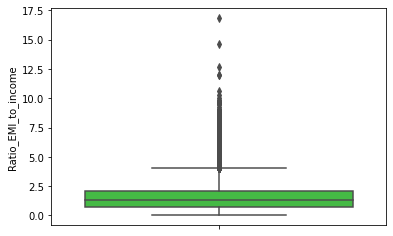

In [15]:
# Impute
train_data['MonthlyIncome'] = np.where(train_data['MonthlyIncome'] <= train_data['MonthlyIncome'].quantile(0.25),
                                       train_data['MonthlyIncome'].quantile(0.25), train_data['MonthlyIncome'])
test_data['MonthlyIncome'] = np.where(test_data['MonthlyIncome'] <= train_data['MonthlyIncome'].quantile(0.25),
                                       train_data['MonthlyIncome'].quantile(0.25), test_data['MonthlyIncome'])
# Impute the NA values with the EMI value
train_data['MonthlyIncome'] = np.where(train_data['MonthlyIncome'].isna(), train_data['MonthlyIncome'].quantile(0.50), 
                                       train_data['MonthlyIncome'])
test_data['MonthlyIncome'] = np.where(test_data['MonthlyIncome'].isna(), train_data['MonthlyIncome'].quantile(0.50), 
                                       test_data['MonthlyIncome'])
# Create ratio of EMI to Income and see its distribution
train_data['Ratio_EMI_to_income'] = train_data['EMI'] / train_data['MonthlyIncome']
test_data['Ratio_EMI_to_income'] = test_data['EMI'] / test_data['MonthlyIncome']
sns.boxplot(train_data['Ratio_EMI_to_income'], orient='v', palette=("limegreen", (0.4,0,0.8)))
plt.show()

Values where EMI>Monthly Income probably indicate non Monthly payment modes or else anomalous values.

In [16]:
# Drop AuthDate as its basically a proxy for Disbursal date
train_data.drop(columns=['AuthDate'], inplace=True)
test_data.drop(columns=['AuthDate'], inplace=True)

In [17]:
# Fill NA's in Age and Sex
train_data['SEX'].fillna('M', inplace=True)
train_data['AGE'].fillna(train_data['AGE'].mean(), inplace=True)
test_data['SEX'].fillna('M', inplace=True)
test_data['AGE'].fillna(train_data['AGE'].mean(), inplace=True)

In [18]:
# For State let's try to see the distribution of the target for each State and group similar ones together if any
# First see the count of observations for each State
train_data['State'].value_counts()

MADHYA PRADESH            19122
ANDHRA PRADESH            18629
UTTAR PRADESH             14449
KARNATAKA                 11569
GUJARAT                   10088
RAJASTHAN                  9668
MAHARASHTRA                9083
HARYANA                    9060
PUNJAB                     6420
WEST BENGAL                5557
CHATTISGARH                5448
BIHAR                      3913
TELANGANA                  2783
ORISSA                     2739
HIMACHAL PRADESH             74
JHARKHAND                    21
UTTARAKHAND                  12
ASSAM                        10
DELHI                         6
CHANDIGARH                    2
TAMIL NADU                    1
DADRA AND NAGAR HAVELI        1
Name: State, dtype: int64

In [19]:
# Combine all the states having  <100 observations into an Other category
def combine_states(state):
    state = re.sub('HIMACHAL PRADESH|JHARKHAND|UTTARAKHAND|ASSAM|DELHI|CHANDIGARH|TAMIL NADU|DADRA AND NAGAR HAVELI',
                          'Other States', state)
    return state
train_data['State'] = train_data['State'].map(combine_states)
test_data['State'] = test_data['State'].map(combine_states)

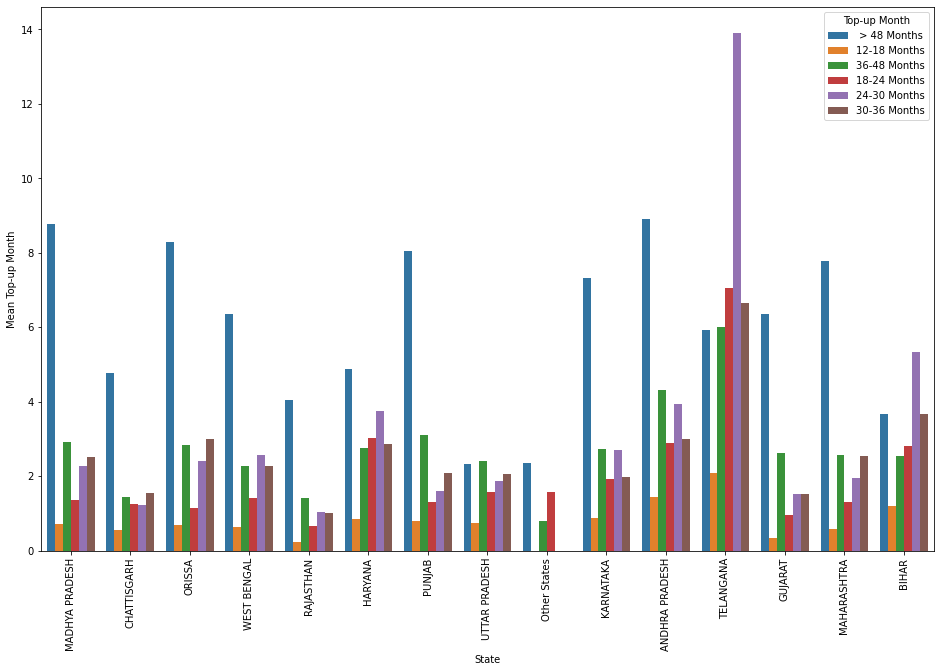

In [20]:
# Let's observe distribution of the classes between remaining States
train_data_State = train_data.loc[:, ['State', 'Top-up Month']]
train_data_State['Count Top-up Month'] = train_data_State.groupby(['State','Top-up Month'])['Top-up Month'].transform('count')
train_data_State['Count State'] = train_data_State.groupby(['State'])['State'].transform('count')
train_data_State['Mean Top-up Month'] = train_data_State['Count Top-up Month'] / train_data_State['Count State'] * 100
# Drop the major category to be able to see the plot better
train_data_State = train_data_State[train_data_State['Top-up Month'] != "No Top-up Service"]
plt.figure(figsize=(16,10))
sns.barplot(x='State', y='Mean Top-up Month',hue='Top-up Month',palette="tab10", data=train_data_State)
plt.xticks(rotation=90)
plt.show()

Though distributions are similar it's better to not combine any of the other States

### For Bureau data

In [21]:
# Drop duplicates in bureau data
train_bureau.drop_duplicates(inplace=True)
train_bureau.reset_index(drop=True, inplace=True)

In [22]:
# Drop variables that have a high percentage of missing values (>30%)
train_bureau.isnull().sum()/train_bureau.shape[0]

ID                           0.000000
SELF-INDICATOR               0.000000
MATCH-TYPE                   0.000000
ACCT-TYPE                    0.000000
CONTRIBUTOR-TYPE             0.000000
DATE-REPORTED                0.006602
OWNERSHIP-IND                0.000000
ACCOUNT-STATUS               0.000000
DISBURSED-DT                 0.057244
CLOSE-DT                     0.446424
LAST-PAYMENT-DATE            0.571374
CREDIT-LIMIT/SANC AMT        0.972884
DISBURSED-AMT/HIGH CREDIT    0.000000
INSTALLMENT-AMT              0.752050
CURRENT-BAL                  0.000417
INSTALLMENT-FREQUENCY        0.760334
OVERDUE-AMT                  0.211938
WRITE-OFF-AMT                0.034247
ASSET_CLASS                  0.537660
REPORTED DATE - HIST         0.034247
DPD - HIST                   0.035062
CUR BAL - HIST               0.034247
AMT OVERDUE - HIST           0.034247
AMT PAID - HIST              0.036342
TENURE                       0.658230
dtype: float64

In [23]:
# We need Last Payment date and Close DT in a later sections. Amt-Paid Hist is not needed
train_bureau.drop(columns=['CREDIT-LIMIT/SANC AMT','INSTALLMENT-AMT','INSTALLMENT-FREQUENCY',
                          'ASSET_CLASS','TENURE'], inplace=True)
test_bureau.drop(columns=['CREDIT-LIMIT/SANC AMT','INSTALLMENT-AMT','INSTALLMENT-FREQUENCY',
                          'ASSET_CLASS','TENURE'], inplace=True)

The bureau data contains entries for the current loan account as well as previous and future Loan accounts for the Customer. So we can create two types of features from here. One set of features will be grouped at the Account level and joined to train while the second set of features will be directly joined at row level using ID, Disbursal Amt and Disbursal date

In [24]:
# Grouped features using Acct Type and Contributor type
train_bureau['Count_Unique_Acct_Types_per_ID'] = train_bureau.groupby(['ID'])['ACCT-TYPE'].transform('nunique')
train_bureau['Count_Unique_Contributor_Types_per_ID'] = train_bureau.groupby(['ID'])['CONTRIBUTOR-TYPE'].transform('nunique')
test_bureau['Count_Unique_Acct_Types_per_ID'] = test_bureau.groupby(['ID'])['ACCT-TYPE'].transform('nunique')
test_bureau['Count_Unique_Contributor_Types_per_ID'] = test_bureau.groupby(['ID'])['CONTRIBUTOR-TYPE'].transform('nunique')

In [25]:
# Account Status- Let's see the levels and merge any similar ones
train_bureau['ACCOUNT-STATUS'].value_counts()

Closed                         319447
Active                         198897
Delinquent                      32410
Written Off                      2931
Suit Filed                       2062
Settled                           624
Restructured                      510
SUIT FILED (WILFUL DEFAULT)        70
WILFUL DEFAULT                     27
Cancelled                           1
Sold/Purchased                      1
Name: ACCOUNT-STATUS, dtype: int64

In [26]:
# Create a Default Category
def combine_acct_status(acct_status):
    acct_status = re.sub('SUIT FILED \(WILFUL DEFAULT\)|Sold/Purchased|Cancelled', 'WILFUL DEFAULT', acct_status)
    return acct_status
train_bureau['ACCOUNT-STATUS'] = train_bureau['ACCOUNT-STATUS'].map(combine_acct_status)
test_bureau['ACCOUNT-STATUS'] = test_bureau['ACCOUNT-STATUS'].map(combine_acct_status)

In [27]:
# Disbursed Amt and Current Bal correction
train_bureau['CURRENT-BAL'].fillna('0', inplace=True)
train_bureau['CURRENT-BAL'] = train_bureau['CURRENT-BAL'].map(amount_correction)
test_bureau['CURRENT-BAL'].fillna('0', inplace=True)
test_bureau['CURRENT-BAL'] = test_bureau['CURRENT-BAL'].map(amount_correction)
# First fill missing values with 0 for Current Amt
train_bureau['DISBURSED-AMT/HIGH CREDIT'] = np.where(train_bureau['DISBURSED-AMT/HIGH CREDIT'].isna(),
                                                     train_bureau['CURRENT-BAL'],
                                                    train_bureau['DISBURSED-AMT/HIGH CREDIT'])
train_bureau['DISBURSED-AMT/HIGH CREDIT'] = train_bureau['DISBURSED-AMT/HIGH CREDIT'].map(amount_correction)
test_bureau['DISBURSED-AMT/HIGH CREDIT'] = np.where(test_bureau['DISBURSED-AMT/HIGH CREDIT'].isna(),
                                                     test_bureau['CURRENT-BAL'],
                                                    test_bureau['DISBURSED-AMT/HIGH CREDIT'])
test_bureau['DISBURSED-AMT/HIGH CREDIT'] = test_bureau['DISBURSED-AMT/HIGH CREDIT'].map(amount_correction)
train_bureau.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,CURRENT-BAL,OVERDUE-AMT,WRITE-OFF-AMT,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,Count_Unique_Acct_Types_per_ID,Count_Unique_Contributor_Types_per_ID
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,...,37873,"37,873",0.0,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",4,2
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,...,20797,NaN,0.0,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",4,2
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,...,116087,0,0.0,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",4,2
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,...,0,0,0.0,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",4,2
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,...,0,0,0.0,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",4,2


Using Disbursal and other dates we need to create following features:- 
* Number of previous Loan Accounts for that ID at the time of Disbursal. Disbursal DT > Disbursal DT of other loan accounts for that ID
* Number of Active Loan Accounts for that ID at the time of Disbursal. Disbursal DT < Reported DT of other Loans where Reported DT > Disbursal DT of previous loan
* Total Money owed from other Loan Accounts at the time of Disbursal- Sum of Curr Bal from No 2
* Total Instances where Overdue Amount > 0 from earlier Loans
* Max Overdue Amt from other Accounts at time of Disbursal
* Total different instances of Late Payments (DPD) from earlier loans
* Total DPD from earlier loans  
However to do all this we first need to treat all these columns and remove missing and incorrect values as much as possible

In [28]:
# Correct Reported and Disbursed dates
train_bureau['DATE-REPORTED'] = train_bureau.apply(lambda x: correct_reported_dt(x['DATE-REPORTED'], x['REPORTED DATE - HIST'], x['LAST-PAYMENT-DATE']), axis=1)
train_bureau['DISBURSED-DT'] = train_bureau.apply(lambda x:correct_disbursed_dt(x['DISBURSED-DT'], x['REPORTED DATE - HIST'], x['DATE-REPORTED']), axis=1)
test_bureau['DATE-REPORTED'] = test_bureau.apply(lambda x: correct_reported_dt(x['DATE-REPORTED'], x['REPORTED DATE - HIST'], x['LAST-PAYMENT-DATE']), axis=1)
test_bureau['DISBURSED-DT'] = test_bureau.apply(lambda x:correct_disbursed_dt(x['DISBURSED-DT'], x['REPORTED DATE - HIST'], x['DATE-REPORTED']), axis=1)

In [29]:
# Drop if still NA's
train_bureau.dropna(subset=['DATE-REPORTED', 'DISBURSED-DT'], inplace=True)
test_bureau.dropna(subset=['DATE-REPORTED', 'DISBURSED-DT'], inplace=True)

In [30]:
# Treat Overdue Amt and Write Off Amt
train_bureau['OVERDUE-AMT'] = train_bureau.apply(lambda x: treat_overdue_amt(x['OVERDUE-AMT'], x['AMT OVERDUE - HIST']), axis=1)
test_bureau['OVERDUE-AMT'] = test_bureau.apply(lambda x: treat_overdue_amt(x['OVERDUE-AMT'], x['AMT OVERDUE - HIST']), axis=1)
# Now convert to numbers
train_bureau['OVERDUE-AMT'] = train_bureau['OVERDUE-AMT'].map(lambda x:re.sub(',', '', str(x)))
train_bureau['OVERDUE-AMT'] = train_bureau['OVERDUE-AMT'].astype(int)
test_bureau['OVERDUE-AMT'] = test_bureau['OVERDUE-AMT'].map(lambda x:re.sub(',', '', str(x)))
test_bureau['OVERDUE-AMT'] = test_bureau['OVERDUE-AMT'].astype(int)
# We have no way to treat Write Off Amt so just replace missing values with 0
train_bureau['WRITE-OFF-AMT'].fillna('0', inplace=True)
train_bureau['WRITE-OFF-AMT'] = train_bureau['WRITE-OFF-AMT'].map(lambda x:re.sub(',', '', str(x)))
train_bureau['WRITE-OFF-AMT'] = train_bureau['WRITE-OFF-AMT'].astype(float)
test_bureau['WRITE-OFF-AMT'].fillna('0', inplace=True)
test_bureau['WRITE-OFF-AMT'] = test_bureau['WRITE-OFF-AMT'].map(lambda x:re.sub(',', '', str(x)))
test_bureau['WRITE-OFF-AMT'] = test_bureau['WRITE-OFF-AMT'].astype(float)

In [31]:
# Correct Close Dates
train_bureau['CLOSE-DT'] = train_bureau.apply(lambda x:correct_close_dt(x['CLOSE-DT'], x['DATE-REPORTED']), axis=1)
test_bureau['CLOSE-DT'] = test_bureau.apply(lambda x:correct_close_dt(x['CLOSE-DT'], x['DATE-REPORTED']), axis=1)

In [32]:
# Create the logic for a Last Active Date
train_bureau['Last Active Date'] = np.where(train_bureau['ACCOUNT-STATUS'] == 'Active',
                                            train_bureau['DATE-REPORTED'],
                                            np.where(train_bureau['CLOSE-DT'].isnull(), train_bureau['LAST-PAYMENT-DATE'], train_bureau['CLOSE-DT']))
train_bureau['Last Active Date'] = np.where(train_bureau['Last Active Date'].isnull(), train_bureau['DATE-REPORTED'], train_bureau['Last Active Date'])
train_bureau['Last Active Date'] = pd.to_datetime(train_bureau['Last Active Date'])
test_bureau['Last Active Date'] = np.where(test_bureau['ACCOUNT-STATUS'] == 'Active',
                                            test_bureau['DATE-REPORTED'],
                                            np.where(test_bureau['CLOSE-DT'].isnull(), test_bureau['LAST-PAYMENT-DATE'], test_bureau['CLOSE-DT']))
test_bureau['Last Active Date'] = np.where(test_bureau['Last Active Date'].isnull(), test_bureau['DATE-REPORTED'], test_bureau['Last Active Date'])
test_bureau['Last Active Date'] = pd.to_datetime(test_bureau['Last Active Date'])

In [33]:
train_bureau.isnull().sum()

ID                                            0
SELF-INDICATOR                                0
MATCH-TYPE                                    0
ACCT-TYPE                                     0
CONTRIBUTOR-TYPE                              0
DATE-REPORTED                                 0
OWNERSHIP-IND                                 0
ACCOUNT-STATUS                                0
DISBURSED-DT                                  0
CLOSE-DT                                 248599
LAST-PAYMENT-DATE                        318194
DISBURSED-AMT/HIGH CREDIT                     0
CURRENT-BAL                                   0
OVERDUE-AMT                                   0
WRITE-OFF-AMT                                 0
REPORTED DATE - HIST                      19025
DPD - HIST                                19479
CUR BAL - HIST                            19025
AMT OVERDUE - HIST                        19025
AMT PAID - HIST                           20192
Count_Unique_Acct_Types_per_ID          

In [34]:
# In order to create Historical features we need to replace NA's in the Historical data cols
train_bureau['DPD - HIST'].fillna('XXX', inplace=True)
train_bureau['REPORTED DATE - HIST'] = np.where(train_bureau['REPORTED DATE - HIST'].isna(), 
                                                train_bureau['DATE-REPORTED'].astype(str) + ',',
                                                train_bureau['REPORTED DATE - HIST'])
train_bureau['CUR BAL - HIST'] = np.where(train_bureau['CUR BAL - HIST'].isna(), 
                                          train_bureau['CURRENT-BAL'].astype(str) + ',',
                                          train_bureau['CUR BAL - HIST'])
train_bureau['AMT OVERDUE - HIST'] = np.where(train_bureau['AMT OVERDUE - HIST'].isna(), 
                                              train_bureau['OVERDUE-AMT'].astype(str) + ',',
                                              train_bureau['AMT OVERDUE - HIST'])
test_bureau['DPD - HIST'].fillna('XXX', inplace=True)
test_bureau['REPORTED DATE - HIST'] = np.where(test_bureau['REPORTED DATE - HIST'].isna(), 
                                               test_bureau['DATE-REPORTED'].astype(str) + ',',
                                               test_bureau['REPORTED DATE - HIST'])
test_bureau['CUR BAL - HIST'] = np.where(test_bureau['CUR BAL - HIST'].isna(), 
                                         test_bureau['CURRENT-BAL'].astype(str) + ',',
                                         test_bureau['CUR BAL - HIST'])
test_bureau['AMT OVERDUE - HIST'] = np.where(test_bureau['AMT OVERDUE - HIST'].isna(), 
                                             test_bureau['OVERDUE-AMT'].astype(str) + ',',
                                             test_bureau['AMT OVERDUE - HIST'])

In [35]:
# Now let's create the historical features
# loan_account_ids = train_bureau['ID'].unique()[:5000]
# train_bureau_with_feats = pd.DataFrame(columns = ['ID', 'DATE-REPORTED', 'DISBURSED-DT', 'Last Active Date', 'CUR BAL - HIST', 'REPORTED DATE - HIST', 'AMT OVERDUE - HIST', 'DPD - HIST'])
# account_ct = 0
# for account in loan_account_ids:
#     individual_cust_data = train_bureau[train_bureau['ID'] == account]
#     individual_cust_data = individual_cust_data.loc[:, ['ID', 'DATE-REPORTED', 'DISBURSED-DT', 'Last Active Date', 'CUR BAL - HIST', 'REPORTED DATE - HIST', 'AMT OVERDUE - HIST', 'DPD - HIST']]
#     # 1) No of past Loan accounts
#     individual_cust_data.sort_values('DISBURSED-DT', inplace=True)
#     individual_cust_data.reset_index(drop=True, inplace=True)
#     individual_cust_data['Previous Loan Accounts'] = individual_cust_data.index
#     # 2) No of past loan accounts stil active at time of Disbursal
#     individual_cust_data['Previous_Active_Disbursal_DT'] = 0
#     for i in np.arange(individual_cust_data.shape[0]):
#         disbursal_dt = individual_cust_data.loc[i, 'DISBURSED-DT']
#         temp_data = individual_cust_data.loc[:i, :]
#         temp_data = temp_data[temp_data['Last Active Date'] > disbursal_dt]
#         active_loan_act_count = temp_data.shape[0]
#         individual_cust_data.loc[i, 'Previous_Active_Disbursal_DT'] = active_loan_act_count - 1
#     train_bureau_with_feats = pd.concat([train_bureau_with_feats, individual_cust_data], axis=0)
#     train_bureau_with_feats['Previous Loan Accounts'] = train_bureau_with_feats['Previous Loan Accounts'].astype(int)
#     train_bureau_with_feats['Previous_Active_Disbursal_DT'] = train_bureau_with_feats['Previous_Active_Disbursal_DT'].astype(int)
# # Every 5000 accounts write the data
# train_bureau_with_feats.loc[:,['ID', 'Previous Loan Accounts', 'Previous_Active_Disbursal_DT']].to_csv('Train_bureau_with_feats.csv', mode='a', index = False, header=None)

In [36]:
# Try the same with a function
# def create_previous_account_count(bureau_data, disbursal_dt):
#     previous_account_df = bureau_data[bureau_data['DISBURSED-DT'] < disbursal_dt]
#     previous_account_df = previous_account_df[previous_account_df['Last Active Date'] > disbursal_dt]
#     active_loan_act_count = previous_account_df.shape[0]
#     return active_loan_act_count

# loan_account_ids = train_bureau['ID'].unique()[:1000]
# train_bureau_with_feats = pd.DataFrame(columns = train_bureau.columns)
# for account in loan_account_ids:
#     individual_cust_data = train_bureau[train_bureau['ID'] == account]
#     # 1) No of past Loan accounts
#     individual_cust_data.sort_values('DISBURSED-DT', inplace=True)
#     individual_cust_data.reset_index(drop=True, inplace=True)
#     individual_cust_data['Previous Loan Accounts'] = individual_cust_data.index
#     # 2) No of past loan accounts stil active at time of Disbursal
#     individual_cust_data['Previous_Active_Disbursal_DT'] = 0
#     individual_cust_data['Previous_Active_Disbursal_DT'] = \
#     individual_cust_data.apply(lambda x:create_previous_account_count(individual_cust_data, x['DISBURSED-DT']), axis=1)
#     train_bureau_with_feats = pd.concat([train_bureau_with_feats, individual_cust_data], axis=0)
#     train_bureau_with_feats['Previous Loan Accounts'] = train_bureau_with_feats['Previous Loan Accounts'].astype(int)
#     train_bureau_with_feats['Previous_Active_Disbursal_DT'] = train_bureau_with_feats['Previous_Active_Disbursal_DT'].astype(int)

In [49]:
# Create Historical Bureau feats- Train
loan_account_ids = train_bureau['ID'].unique()[110000:120000]
#train_bureau_with_feats = pd.DataFrame(columns = ['ID', 'DATE-REPORTED', 'DISBURSED-DT', 'Last Active Date', 'CUR BAL - HIST', 'REPORTED DATE - HIST', 'AMT OVERDUE - HIST', 'DPD - HIST'])
train_bureau_with_feats = pd.DataFrame(columns=train_bureau.columns)
train_bureau_with_more_historical_feats = pd.DataFrame(columns = train_bureau_with_feats.columns)
for account in loan_account_ids:
    print('Generating feats for Account No: ', account)
    individual_cust_data = train_bureau[train_bureau['ID'] == account]
    #individual_cust_data = individual_cust_data.loc[:, ['ID', 'DATE-REPORTED', 'DISBURSED-DT', 'Last Active Date', 'CUR BAL - HIST', 'REPORTED DATE - HIST', 'AMT OVERDUE - HIST', 'DPD - HIST']]
    # Historical feats
    individual_cust_data_with_feats = generate_historical_loan_feats_customer_level(individual_cust_data)
    train_bureau_with_feats = pd.concat([train_bureau_with_feats, individual_cust_data_with_feats])
train_bureau_with_feats.loc[:, ['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
                               'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
                               'CLOSE-DT', 'LAST-PAYMENT-DATE', 'DISBURSED-AMT/HIGH CREDIT',
                               'CURRENT-BAL', 'OVERDUE-AMT', 'WRITE-OFF-AMT',
                               'Count_Unique_Acct_Types_per_ID',
                               'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                               'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                               'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                               'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                               'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count','Unique_Acct_Type_count']].to_csv('../Data/Train/Train_bureau_with_historical_feats.csv', index=False, mode='a', header=None)

Generating feats for Account No:  123204
Generating feats for Account No:  123205
Generating feats for Account No:  123206
Generating feats for Account No:  123207
Generating feats for Account No:  123208
Generating feats for Account No:  123209
Generating feats for Account No:  123211
Generating feats for Account No:  123212
Generating feats for Account No:  123213
Generating feats for Account No:  123214
Generating feats for Account No:  123215
Generating feats for Account No:  123216
Generating feats for Account No:  123217
Generating feats for Account No:  123218
Generating feats for Account No:  123219
Generating feats for Account No:  123220
Generating feats for Account No:  123221
Generating feats for Account No:  123222
Generating feats for Account No:  123223
Generating feats for Account No:  123224
Generating feats for Account No:  123225
Generating feats for Account No:  123226
Generating feats for Account No:  123227
Generating feats for Account No:  123228
Generating feats

Generating feats for Account No:  123442
Generating feats for Account No:  123443
Generating feats for Account No:  123444
Generating feats for Account No:  123446
Generating feats for Account No:  123447
Generating feats for Account No:  123448
Generating feats for Account No:  123449
Generating feats for Account No:  123450
Generating feats for Account No:  123451
Generating feats for Account No:  123452
Generating feats for Account No:  123453
Generating feats for Account No:  123454
Generating feats for Account No:  123455
Generating feats for Account No:  123456
Generating feats for Account No:  123457
Generating feats for Account No:  123458
Generating feats for Account No:  123459
Generating feats for Account No:  123460
Generating feats for Account No:  123461
Generating feats for Account No:  123462
Generating feats for Account No:  123464
Generating feats for Account No:  123465
Generating feats for Account No:  123466
Generating feats for Account No:  123467
Generating feats

Generating feats for Account No:  123667
Generating feats for Account No:  123668
Generating feats for Account No:  123669
Generating feats for Account No:  123670
Generating feats for Account No:  123671
Generating feats for Account No:  123672
Generating feats for Account No:  123673
Generating feats for Account No:  123674
Generating feats for Account No:  123675
Generating feats for Account No:  123676
Generating feats for Account No:  123677
Generating feats for Account No:  123678
Generating feats for Account No:  123679
Generating feats for Account No:  123680
Generating feats for Account No:  123681
Generating feats for Account No:  123682
Generating feats for Account No:  123683
Generating feats for Account No:  123684
Generating feats for Account No:  123685
Generating feats for Account No:  123686
Generating feats for Account No:  123687
Generating feats for Account No:  123688
Generating feats for Account No:  123689
Generating feats for Account No:  123690
Generating feats

Generating feats for Account No:  123878
Generating feats for Account No:  123879
Generating feats for Account No:  123880
Generating feats for Account No:  123881
Generating feats for Account No:  123883
Generating feats for Account No:  123884
Generating feats for Account No:  123885
Generating feats for Account No:  123886
Generating feats for Account No:  123887
Generating feats for Account No:  123888
Generating feats for Account No:  123889
Generating feats for Account No:  123890
Generating feats for Account No:  123891
Generating feats for Account No:  123892
Generating feats for Account No:  123893
Generating feats for Account No:  123894
Generating feats for Account No:  123895
Generating feats for Account No:  123896
Generating feats for Account No:  123897
Generating feats for Account No:  123898
Generating feats for Account No:  123899
Generating feats for Account No:  123900
Generating feats for Account No:  123901
Generating feats for Account No:  123902
Generating feats

Generating feats for Account No:  124095
Generating feats for Account No:  124096
Generating feats for Account No:  124097
Generating feats for Account No:  124098
Generating feats for Account No:  124099
Generating feats for Account No:  124100
Generating feats for Account No:  124101
Generating feats for Account No:  124102
Generating feats for Account No:  124103
Generating feats for Account No:  124104
Generating feats for Account No:  124105
Generating feats for Account No:  124106
Generating feats for Account No:  124107
Generating feats for Account No:  124108
Generating feats for Account No:  124109
Generating feats for Account No:  124110
Generating feats for Account No:  124111
Generating feats for Account No:  124112
Generating feats for Account No:  124113
Generating feats for Account No:  124114
Generating feats for Account No:  124115
Generating feats for Account No:  124116
Generating feats for Account No:  124117
Generating feats for Account No:  124118
Generating feats

Generating feats for Account No:  124296
Generating feats for Account No:  124297
Generating feats for Account No:  124298
Generating feats for Account No:  124299
Generating feats for Account No:  124300
Generating feats for Account No:  124301
Generating feats for Account No:  124302
Generating feats for Account No:  124303
Generating feats for Account No:  124304
Generating feats for Account No:  124305
Generating feats for Account No:  124306
Generating feats for Account No:  124307
Generating feats for Account No:  124308
Generating feats for Account No:  124309
Generating feats for Account No:  124310
Generating feats for Account No:  124311
Generating feats for Account No:  124312
Generating feats for Account No:  124313
Generating feats for Account No:  124314
Generating feats for Account No:  124315
Generating feats for Account No:  124316
Generating feats for Account No:  124317
Generating feats for Account No:  124318
Generating feats for Account No:  124319
Generating feats

Generating feats for Account No:  124497
Generating feats for Account No:  124498
Generating feats for Account No:  124499
Generating feats for Account No:  124500
Generating feats for Account No:  124501
Generating feats for Account No:  124502
Generating feats for Account No:  124503
Generating feats for Account No:  124504
Generating feats for Account No:  124505
Generating feats for Account No:  124506
Generating feats for Account No:  124507
Generating feats for Account No:  124508
Generating feats for Account No:  124509
Generating feats for Account No:  124510
Generating feats for Account No:  124511
Generating feats for Account No:  124512
Generating feats for Account No:  124513
Generating feats for Account No:  124514
Generating feats for Account No:  124515
Generating feats for Account No:  124516
Generating feats for Account No:  124517
Generating feats for Account No:  124518
Generating feats for Account No:  124519
Generating feats for Account No:  124520
Generating feats

Generating feats for Account No:  124710
Generating feats for Account No:  124711
Generating feats for Account No:  124712
Generating feats for Account No:  124713
Generating feats for Account No:  124714
Generating feats for Account No:  124715
Generating feats for Account No:  124716
Generating feats for Account No:  124717
Generating feats for Account No:  124718
Generating feats for Account No:  124719
Generating feats for Account No:  124720
Generating feats for Account No:  124721
Generating feats for Account No:  124722
Generating feats for Account No:  124723
Generating feats for Account No:  124724
Generating feats for Account No:  124725
Generating feats for Account No:  124726
Generating feats for Account No:  124727
Generating feats for Account No:  124728
Generating feats for Account No:  124729
Generating feats for Account No:  124730
Generating feats for Account No:  124731
Generating feats for Account No:  124732
Generating feats for Account No:  124733
Generating feats

Generating feats for Account No:  124915
Generating feats for Account No:  124916
Generating feats for Account No:  124917
Generating feats for Account No:  124918
Generating feats for Account No:  124919
Generating feats for Account No:  124920
Generating feats for Account No:  124921
Generating feats for Account No:  124922
Generating feats for Account No:  124923
Generating feats for Account No:  124924
Generating feats for Account No:  124925
Generating feats for Account No:  124926
Generating feats for Account No:  124927
Generating feats for Account No:  124928
Generating feats for Account No:  124929
Generating feats for Account No:  124930
Generating feats for Account No:  124931
Generating feats for Account No:  124932
Generating feats for Account No:  124933
Generating feats for Account No:  124934
Generating feats for Account No:  124935
Generating feats for Account No:  124936
Generating feats for Account No:  124937
Generating feats for Account No:  124938
Generating feats

Generating feats for Account No:  125132
Generating feats for Account No:  125133
Generating feats for Account No:  125134
Generating feats for Account No:  125135
Generating feats for Account No:  125136
Generating feats for Account No:  125137
Generating feats for Account No:  125138
Generating feats for Account No:  125139
Generating feats for Account No:  125140
Generating feats for Account No:  125141
Generating feats for Account No:  125142
Generating feats for Account No:  125143
Generating feats for Account No:  125144
Generating feats for Account No:  125145
Generating feats for Account No:  125146
Generating feats for Account No:  125147
Generating feats for Account No:  125148
Generating feats for Account No:  125149
Generating feats for Account No:  125150
Generating feats for Account No:  125151
Generating feats for Account No:  125152
Generating feats for Account No:  125153
Generating feats for Account No:  125154
Generating feats for Account No:  125155
Generating feats

Generating feats for Account No:  125345
Generating feats for Account No:  125346
Generating feats for Account No:  125347
Generating feats for Account No:  125348
Generating feats for Account No:  125349
Generating feats for Account No:  125350
Generating feats for Account No:  125351
Generating feats for Account No:  125352
Generating feats for Account No:  125353
Generating feats for Account No:  125354
Generating feats for Account No:  125355
Generating feats for Account No:  125356
Generating feats for Account No:  125357
Generating feats for Account No:  125358
Generating feats for Account No:  125359
Generating feats for Account No:  125360
Generating feats for Account No:  125361
Generating feats for Account No:  125362
Generating feats for Account No:  125363
Generating feats for Account No:  125364
Generating feats for Account No:  125365
Generating feats for Account No:  125367
Generating feats for Account No:  125368
Generating feats for Account No:  125369
Generating feats

Generating feats for Account No:  125551
Generating feats for Account No:  125552
Generating feats for Account No:  125553
Generating feats for Account No:  125554
Generating feats for Account No:  125555
Generating feats for Account No:  125556
Generating feats for Account No:  125557
Generating feats for Account No:  125559
Generating feats for Account No:  125560
Generating feats for Account No:  125561
Generating feats for Account No:  125562
Generating feats for Account No:  125563
Generating feats for Account No:  125564
Generating feats for Account No:  125565
Generating feats for Account No:  125566
Generating feats for Account No:  125567
Generating feats for Account No:  125569
Generating feats for Account No:  125570
Generating feats for Account No:  125571
Generating feats for Account No:  125572
Generating feats for Account No:  125573
Generating feats for Account No:  125574
Generating feats for Account No:  125575
Generating feats for Account No:  125576
Generating feats

Generating feats for Account No:  125757
Generating feats for Account No:  125758
Generating feats for Account No:  125759
Generating feats for Account No:  125760
Generating feats for Account No:  125761
Generating feats for Account No:  125762
Generating feats for Account No:  125763
Generating feats for Account No:  125764
Generating feats for Account No:  125765
Generating feats for Account No:  125766
Generating feats for Account No:  125767
Generating feats for Account No:  125768
Generating feats for Account No:  125769
Generating feats for Account No:  125770
Generating feats for Account No:  125771
Generating feats for Account No:  125772
Generating feats for Account No:  125773
Generating feats for Account No:  125774
Generating feats for Account No:  125775
Generating feats for Account No:  125776
Generating feats for Account No:  125777
Generating feats for Account No:  125778
Generating feats for Account No:  125779
Generating feats for Account No:  125780
Generating feats

Generating feats for Account No:  125964
Generating feats for Account No:  125965
Generating feats for Account No:  125966
Generating feats for Account No:  125967
Generating feats for Account No:  125968
Generating feats for Account No:  125969
Generating feats for Account No:  125970
Generating feats for Account No:  125972
Generating feats for Account No:  125973
Generating feats for Account No:  125974
Generating feats for Account No:  125975
Generating feats for Account No:  125976
Generating feats for Account No:  125977
Generating feats for Account No:  125978
Generating feats for Account No:  125979
Generating feats for Account No:  125980
Generating feats for Account No:  125981
Generating feats for Account No:  125982
Generating feats for Account No:  125984
Generating feats for Account No:  125985
Generating feats for Account No:  125986
Generating feats for Account No:  125987
Generating feats for Account No:  125988
Generating feats for Account No:  125989
Generating feats

Generating feats for Account No:  126204
Generating feats for Account No:  126205
Generating feats for Account No:  126206
Generating feats for Account No:  126207
Generating feats for Account No:  126208
Generating feats for Account No:  126209
Generating feats for Account No:  126210
Generating feats for Account No:  126211
Generating feats for Account No:  126212
Generating feats for Account No:  126213
Generating feats for Account No:  126214
Generating feats for Account No:  126215
Generating feats for Account No:  126216
Generating feats for Account No:  126217
Generating feats for Account No:  126219
Generating feats for Account No:  126220
Generating feats for Account No:  126221
Generating feats for Account No:  126222
Generating feats for Account No:  126223
Generating feats for Account No:  126224
Generating feats for Account No:  126225
Generating feats for Account No:  126226
Generating feats for Account No:  126227
Generating feats for Account No:  126228
Generating feats

Generating feats for Account No:  126410
Generating feats for Account No:  126411
Generating feats for Account No:  126412
Generating feats for Account No:  126413
Generating feats for Account No:  126414
Generating feats for Account No:  126415
Generating feats for Account No:  126416
Generating feats for Account No:  126417
Generating feats for Account No:  126418
Generating feats for Account No:  126419
Generating feats for Account No:  126420
Generating feats for Account No:  126422
Generating feats for Account No:  126423
Generating feats for Account No:  126424
Generating feats for Account No:  126425
Generating feats for Account No:  126426
Generating feats for Account No:  126427
Generating feats for Account No:  126428
Generating feats for Account No:  126429
Generating feats for Account No:  126430
Generating feats for Account No:  126431
Generating feats for Account No:  126432
Generating feats for Account No:  126433
Generating feats for Account No:  126434
Generating feats

Generating feats for Account No:  126617
Generating feats for Account No:  126618
Generating feats for Account No:  126619
Generating feats for Account No:  126620
Generating feats for Account No:  126621
Generating feats for Account No:  126622
Generating feats for Account No:  126623
Generating feats for Account No:  126624
Generating feats for Account No:  126625
Generating feats for Account No:  126626
Generating feats for Account No:  126627
Generating feats for Account No:  126628
Generating feats for Account No:  126629
Generating feats for Account No:  126630
Generating feats for Account No:  126631
Generating feats for Account No:  126632
Generating feats for Account No:  126633
Generating feats for Account No:  126634
Generating feats for Account No:  126635
Generating feats for Account No:  126636
Generating feats for Account No:  126637
Generating feats for Account No:  126638
Generating feats for Account No:  126639
Generating feats for Account No:  126640
Generating feats

Generating feats for Account No:  126828
Generating feats for Account No:  126829
Generating feats for Account No:  126830
Generating feats for Account No:  126831
Generating feats for Account No:  126832
Generating feats for Account No:  126833
Generating feats for Account No:  126834
Generating feats for Account No:  126835
Generating feats for Account No:  126836
Generating feats for Account No:  126837
Generating feats for Account No:  126838
Generating feats for Account No:  126839
Generating feats for Account No:  126840
Generating feats for Account No:  126841
Generating feats for Account No:  126842
Generating feats for Account No:  126843
Generating feats for Account No:  126844
Generating feats for Account No:  126845
Generating feats for Account No:  126846
Generating feats for Account No:  126847
Generating feats for Account No:  126848
Generating feats for Account No:  126849
Generating feats for Account No:  126850
Generating feats for Account No:  126851
Generating feats

Generating feats for Account No:  127038
Generating feats for Account No:  127040
Generating feats for Account No:  127041
Generating feats for Account No:  127042
Generating feats for Account No:  127043
Generating feats for Account No:  127044
Generating feats for Account No:  127045
Generating feats for Account No:  127046
Generating feats for Account No:  127047
Generating feats for Account No:  127049
Generating feats for Account No:  127050
Generating feats for Account No:  127051
Generating feats for Account No:  127052
Generating feats for Account No:  127053
Generating feats for Account No:  127054
Generating feats for Account No:  127056
Generating feats for Account No:  127057
Generating feats for Account No:  127058
Generating feats for Account No:  127059
Generating feats for Account No:  127060
Generating feats for Account No:  127061
Generating feats for Account No:  127062
Generating feats for Account No:  127065
Generating feats for Account No:  127066
Generating feats

Generating feats for Account No:  127270
Generating feats for Account No:  127271
Generating feats for Account No:  127272
Generating feats for Account No:  127273
Generating feats for Account No:  127274
Generating feats for Account No:  127275
Generating feats for Account No:  127276
Generating feats for Account No:  127277
Generating feats for Account No:  127278
Generating feats for Account No:  127279
Generating feats for Account No:  127280
Generating feats for Account No:  127281
Generating feats for Account No:  127282
Generating feats for Account No:  127283
Generating feats for Account No:  127284
Generating feats for Account No:  127285
Generating feats for Account No:  127286
Generating feats for Account No:  127287
Generating feats for Account No:  127288
Generating feats for Account No:  127289
Generating feats for Account No:  127290
Generating feats for Account No:  127291
Generating feats for Account No:  127292
Generating feats for Account No:  127293
Generating feats

Generating feats for Account No:  127515
Generating feats for Account No:  127516
Generating feats for Account No:  127517
Generating feats for Account No:  127518
Generating feats for Account No:  127519
Generating feats for Account No:  127520
Generating feats for Account No:  127521
Generating feats for Account No:  127522
Generating feats for Account No:  127523
Generating feats for Account No:  127524
Generating feats for Account No:  127525
Generating feats for Account No:  127526
Generating feats for Account No:  127527
Generating feats for Account No:  127528
Generating feats for Account No:  127529
Generating feats for Account No:  127530
Generating feats for Account No:  127531
Generating feats for Account No:  127532
Generating feats for Account No:  127533
Generating feats for Account No:  127534
Generating feats for Account No:  127535
Generating feats for Account No:  127536
Generating feats for Account No:  127537
Generating feats for Account No:  127538
Generating feats

Generating feats for Account No:  127729
Generating feats for Account No:  127731
Generating feats for Account No:  127732
Generating feats for Account No:  127733
Generating feats for Account No:  127734
Generating feats for Account No:  127735
Generating feats for Account No:  127736
Generating feats for Account No:  127737
Generating feats for Account No:  127738
Generating feats for Account No:  127739
Generating feats for Account No:  127740
Generating feats for Account No:  127741
Generating feats for Account No:  127742
Generating feats for Account No:  127743
Generating feats for Account No:  127744
Generating feats for Account No:  127745
Generating feats for Account No:  127746
Generating feats for Account No:  127747
Generating feats for Account No:  127748
Generating feats for Account No:  127749
Generating feats for Account No:  127750
Generating feats for Account No:  127751
Generating feats for Account No:  127752
Generating feats for Account No:  127753
Generating feats

Generating feats for Account No:  127931
Generating feats for Account No:  127932
Generating feats for Account No:  127933
Generating feats for Account No:  127934
Generating feats for Account No:  127935
Generating feats for Account No:  127936
Generating feats for Account No:  127937
Generating feats for Account No:  127938
Generating feats for Account No:  127939
Generating feats for Account No:  127940
Generating feats for Account No:  127941
Generating feats for Account No:  127942
Generating feats for Account No:  127943
Generating feats for Account No:  127944
Generating feats for Account No:  127945
Generating feats for Account No:  127946
Generating feats for Account No:  127947
Generating feats for Account No:  127948
Generating feats for Account No:  127949
Generating feats for Account No:  127950
Generating feats for Account No:  127951
Generating feats for Account No:  127952
Generating feats for Account No:  127953
Generating feats for Account No:  127954
Generating feats

Generating feats for Account No:  128133
Generating feats for Account No:  128134
Generating feats for Account No:  128135
Generating feats for Account No:  128136
Generating feats for Account No:  128137
Generating feats for Account No:  128138
Generating feats for Account No:  128139
Generating feats for Account No:  128140
Generating feats for Account No:  128141
Generating feats for Account No:  128142
Generating feats for Account No:  128143
Generating feats for Account No:  128144
Generating feats for Account No:  128145
Generating feats for Account No:  128146
Generating feats for Account No:  128147
Generating feats for Account No:  128148
Generating feats for Account No:  128149
Generating feats for Account No:  128150
Generating feats for Account No:  128151
Generating feats for Account No:  128152
Generating feats for Account No:  128153
Generating feats for Account No:  128154
Generating feats for Account No:  128155
Generating feats for Account No:  128156
Generating feats

Generating feats for Account No:  128336
Generating feats for Account No:  128337
Generating feats for Account No:  128338
Generating feats for Account No:  128339
Generating feats for Account No:  128340
Generating feats for Account No:  128341
Generating feats for Account No:  128342
Generating feats for Account No:  128343
Generating feats for Account No:  128344
Generating feats for Account No:  128345
Generating feats for Account No:  128346
Generating feats for Account No:  128347
Generating feats for Account No:  128348
Generating feats for Account No:  128349
Generating feats for Account No:  128350
Generating feats for Account No:  128351
Generating feats for Account No:  128352
Generating feats for Account No:  128353
Generating feats for Account No:  128354
Generating feats for Account No:  128355
Generating feats for Account No:  128356
Generating feats for Account No:  128357
Generating feats for Account No:  128358
Generating feats for Account No:  128359
Generating feats

Generating feats for Account No:  128545
Generating feats for Account No:  128546
Generating feats for Account No:  128547
Generating feats for Account No:  128548
Generating feats for Account No:  128549
Generating feats for Account No:  128550
Generating feats for Account No:  128551
Generating feats for Account No:  128552
Generating feats for Account No:  128553
Generating feats for Account No:  128554
Generating feats for Account No:  128555
Generating feats for Account No:  128556
Generating feats for Account No:  128557
Generating feats for Account No:  128558
Generating feats for Account No:  128559
Generating feats for Account No:  128560
Generating feats for Account No:  128561
Generating feats for Account No:  128562
Generating feats for Account No:  128563
Generating feats for Account No:  128564
Generating feats for Account No:  128565
Generating feats for Account No:  128566
Generating feats for Account No:  128567
Generating feats for Account No:  128568
Generating feats

Generating feats for Account No:  128769
Generating feats for Account No:  128770
Generating feats for Account No:  128771
Generating feats for Account No:  128773
Generating feats for Account No:  128774
Generating feats for Account No:  128776
Generating feats for Account No:  128777
Generating feats for Account No:  128778
Generating feats for Account No:  128779
Generating feats for Account No:  128780
Generating feats for Account No:  128781
Generating feats for Account No:  128782
Generating feats for Account No:  128783
Generating feats for Account No:  128784
Generating feats for Account No:  128785
Generating feats for Account No:  128786
Generating feats for Account No:  128787
Generating feats for Account No:  128789
Generating feats for Account No:  128790
Generating feats for Account No:  128791
Generating feats for Account No:  128792
Generating feats for Account No:  128793
Generating feats for Account No:  128794
Generating feats for Account No:  128795
Generating feats

Generating feats for Account No:  128981
Generating feats for Account No:  128982
Generating feats for Account No:  128983
Generating feats for Account No:  128984
Generating feats for Account No:  128985
Generating feats for Account No:  128986
Generating feats for Account No:  128987
Generating feats for Account No:  128988
Generating feats for Account No:  128989
Generating feats for Account No:  128990
Generating feats for Account No:  128991
Generating feats for Account No:  128992
Generating feats for Account No:  128993
Generating feats for Account No:  128994
Generating feats for Account No:  128995
Generating feats for Account No:  128996
Generating feats for Account No:  128997
Generating feats for Account No:  128998
Generating feats for Account No:  128999
Generating feats for Account No:  129000
Generating feats for Account No:  129001
Generating feats for Account No:  129002
Generating feats for Account No:  129003
Generating feats for Account No:  129004
Generating feats

Generating feats for Account No:  129185
Generating feats for Account No:  129186
Generating feats for Account No:  129187
Generating feats for Account No:  129188
Generating feats for Account No:  129189
Generating feats for Account No:  129190
Generating feats for Account No:  129191
Generating feats for Account No:  129192
Generating feats for Account No:  129193
Generating feats for Account No:  129194
Generating feats for Account No:  129195
Generating feats for Account No:  129196
Generating feats for Account No:  129197
Generating feats for Account No:  129198
Generating feats for Account No:  129199
Generating feats for Account No:  129200
Generating feats for Account No:  129201
Generating feats for Account No:  129202
Generating feats for Account No:  129203
Generating feats for Account No:  129204
Generating feats for Account No:  129205
Generating feats for Account No:  129206
Generating feats for Account No:  129207
Generating feats for Account No:  129208
Generating feats

Generating feats for Account No:  129386
Generating feats for Account No:  129387
Generating feats for Account No:  129388
Generating feats for Account No:  129389
Generating feats for Account No:  129390
Generating feats for Account No:  129391
Generating feats for Account No:  129392
Generating feats for Account No:  129393
Generating feats for Account No:  129394
Generating feats for Account No:  129395
Generating feats for Account No:  129396
Generating feats for Account No:  129397
Generating feats for Account No:  129398
Generating feats for Account No:  129399
Generating feats for Account No:  129400
Generating feats for Account No:  129401
Generating feats for Account No:  129402
Generating feats for Account No:  129403
Generating feats for Account No:  129404
Generating feats for Account No:  129405
Generating feats for Account No:  129406
Generating feats for Account No:  129407
Generating feats for Account No:  129408
Generating feats for Account No:  129409
Generating feats

Generating feats for Account No:  129590
Generating feats for Account No:  129591
Generating feats for Account No:  129592
Generating feats for Account No:  129593
Generating feats for Account No:  129594
Generating feats for Account No:  129595
Generating feats for Account No:  129596
Generating feats for Account No:  129597
Generating feats for Account No:  129598
Generating feats for Account No:  129599
Generating feats for Account No:  129600
Generating feats for Account No:  129601
Generating feats for Account No:  129602
Generating feats for Account No:  129603
Generating feats for Account No:  129604
Generating feats for Account No:  129605
Generating feats for Account No:  129606
Generating feats for Account No:  129607
Generating feats for Account No:  129608
Generating feats for Account No:  129609
Generating feats for Account No:  129610
Generating feats for Account No:  129611
Generating feats for Account No:  129612
Generating feats for Account No:  129613
Generating feats

Generating feats for Account No:  129792
Generating feats for Account No:  129793
Generating feats for Account No:  129794
Generating feats for Account No:  129795
Generating feats for Account No:  129796
Generating feats for Account No:  129797
Generating feats for Account No:  129798
Generating feats for Account No:  129799
Generating feats for Account No:  129800
Generating feats for Account No:  129801
Generating feats for Account No:  129802
Generating feats for Account No:  129803
Generating feats for Account No:  129804
Generating feats for Account No:  129805
Generating feats for Account No:  129806
Generating feats for Account No:  129807
Generating feats for Account No:  129808
Generating feats for Account No:  129809
Generating feats for Account No:  129810
Generating feats for Account No:  129811
Generating feats for Account No:  129812
Generating feats for Account No:  129813
Generating feats for Account No:  129814
Generating feats for Account No:  129815
Generating feats

Generating feats for Account No:  129993
Generating feats for Account No:  129994
Generating feats for Account No:  129995
Generating feats for Account No:  129996
Generating feats for Account No:  129997
Generating feats for Account No:  129998
Generating feats for Account No:  129999
Generating feats for Account No:  130000
Generating feats for Account No:  130001
Generating feats for Account No:  130002
Generating feats for Account No:  130003
Generating feats for Account No:  130004
Generating feats for Account No:  130005
Generating feats for Account No:  130006
Generating feats for Account No:  130007
Generating feats for Account No:  130008
Generating feats for Account No:  130009
Generating feats for Account No:  130010
Generating feats for Account No:  130011
Generating feats for Account No:  130012
Generating feats for Account No:  130013
Generating feats for Account No:  130014
Generating feats for Account No:  130015
Generating feats for Account No:  130016
Generating feats

Generating feats for Account No:  130194
Generating feats for Account No:  130195
Generating feats for Account No:  130196
Generating feats for Account No:  130197
Generating feats for Account No:  130198
Generating feats for Account No:  130199
Generating feats for Account No:  130200
Generating feats for Account No:  130201
Generating feats for Account No:  130202
Generating feats for Account No:  130203
Generating feats for Account No:  130204
Generating feats for Account No:  130205
Generating feats for Account No:  130206
Generating feats for Account No:  130207
Generating feats for Account No:  130208
Generating feats for Account No:  130209
Generating feats for Account No:  130210
Generating feats for Account No:  130211
Generating feats for Account No:  130212
Generating feats for Account No:  130213
Generating feats for Account No:  130214
Generating feats for Account No:  130215
Generating feats for Account No:  130216
Generating feats for Account No:  130217
Generating feats

Generating feats for Account No:  130399
Generating feats for Account No:  130400
Generating feats for Account No:  130401
Generating feats for Account No:  130402
Generating feats for Account No:  130403
Generating feats for Account No:  130404
Generating feats for Account No:  130405
Generating feats for Account No:  130406
Generating feats for Account No:  130407
Generating feats for Account No:  130408
Generating feats for Account No:  130409
Generating feats for Account No:  130410
Generating feats for Account No:  130411
Generating feats for Account No:  130412
Generating feats for Account No:  130413
Generating feats for Account No:  130414
Generating feats for Account No:  130415
Generating feats for Account No:  130416
Generating feats for Account No:  130417
Generating feats for Account No:  130418
Generating feats for Account No:  130419
Generating feats for Account No:  130420
Generating feats for Account No:  130421
Generating feats for Account No:  130422
Generating feats

Generating feats for Account No:  130631
Generating feats for Account No:  130632
Generating feats for Account No:  130633
Generating feats for Account No:  130634
Generating feats for Account No:  130635
Generating feats for Account No:  130636
Generating feats for Account No:  130637
Generating feats for Account No:  130638
Generating feats for Account No:  130639
Generating feats for Account No:  130640
Generating feats for Account No:  130641
Generating feats for Account No:  130642
Generating feats for Account No:  130643
Generating feats for Account No:  130644
Generating feats for Account No:  130645
Generating feats for Account No:  130646
Generating feats for Account No:  130647
Generating feats for Account No:  130648
Generating feats for Account No:  130649
Generating feats for Account No:  130650
Generating feats for Account No:  130651
Generating feats for Account No:  130652
Generating feats for Account No:  130653
Generating feats for Account No:  130654
Generating feats

Generating feats for Account No:  130835
Generating feats for Account No:  130836
Generating feats for Account No:  130837
Generating feats for Account No:  130838
Generating feats for Account No:  130839
Generating feats for Account No:  130840
Generating feats for Account No:  130841
Generating feats for Account No:  130842
Generating feats for Account No:  130843
Generating feats for Account No:  130844
Generating feats for Account No:  130845
Generating feats for Account No:  130846
Generating feats for Account No:  130847
Generating feats for Account No:  130848
Generating feats for Account No:  130849
Generating feats for Account No:  130850
Generating feats for Account No:  130851
Generating feats for Account No:  130852
Generating feats for Account No:  130853
Generating feats for Account No:  130854
Generating feats for Account No:  130855
Generating feats for Account No:  130856
Generating feats for Account No:  130857
Generating feats for Account No:  130858
Generating feats

Generating feats for Account No:  131045
Generating feats for Account No:  131046
Generating feats for Account No:  131047
Generating feats for Account No:  131048
Generating feats for Account No:  131049
Generating feats for Account No:  131050
Generating feats for Account No:  131051
Generating feats for Account No:  131052
Generating feats for Account No:  131054
Generating feats for Account No:  131055
Generating feats for Account No:  131056
Generating feats for Account No:  131057
Generating feats for Account No:  131058
Generating feats for Account No:  131059
Generating feats for Account No:  131060
Generating feats for Account No:  131061
Generating feats for Account No:  131062
Generating feats for Account No:  131063
Generating feats for Account No:  131064
Generating feats for Account No:  131065
Generating feats for Account No:  131066
Generating feats for Account No:  131067
Generating feats for Account No:  131068
Generating feats for Account No:  131069
Generating feats

Generating feats for Account No:  131246
Generating feats for Account No:  131247
Generating feats for Account No:  131248
Generating feats for Account No:  131249
Generating feats for Account No:  131250
Generating feats for Account No:  131251
Generating feats for Account No:  131252
Generating feats for Account No:  131253
Generating feats for Account No:  131254
Generating feats for Account No:  131255
Generating feats for Account No:  131256
Generating feats for Account No:  131257
Generating feats for Account No:  131258
Generating feats for Account No:  131259
Generating feats for Account No:  131260
Generating feats for Account No:  131261
Generating feats for Account No:  131262
Generating feats for Account No:  131263
Generating feats for Account No:  131264
Generating feats for Account No:  131265
Generating feats for Account No:  131266
Generating feats for Account No:  131267
Generating feats for Account No:  131268
Generating feats for Account No:  131269
Generating feats

Generating feats for Account No:  131450
Generating feats for Account No:  131451
Generating feats for Account No:  131452
Generating feats for Account No:  131453
Generating feats for Account No:  131454
Generating feats for Account No:  131456
Generating feats for Account No:  131457
Generating feats for Account No:  131458
Generating feats for Account No:  131459
Generating feats for Account No:  131460
Generating feats for Account No:  131461
Generating feats for Account No:  131463
Generating feats for Account No:  131464
Generating feats for Account No:  131465
Generating feats for Account No:  131466
Generating feats for Account No:  131467
Generating feats for Account No:  131468
Generating feats for Account No:  131469
Generating feats for Account No:  131470
Generating feats for Account No:  131471
Generating feats for Account No:  131472
Generating feats for Account No:  131473
Generating feats for Account No:  131474
Generating feats for Account No:  131475
Generating feats

Generating feats for Account No:  131727
Generating feats for Account No:  131728
Generating feats for Account No:  131729
Generating feats for Account No:  131730
Generating feats for Account No:  131732
Generating feats for Account No:  131733
Generating feats for Account No:  131734
Generating feats for Account No:  131735
Generating feats for Account No:  131736
Generating feats for Account No:  131737
Generating feats for Account No:  131738
Generating feats for Account No:  131739
Generating feats for Account No:  131740
Generating feats for Account No:  131742
Generating feats for Account No:  131743
Generating feats for Account No:  131744
Generating feats for Account No:  131745
Generating feats for Account No:  131746
Generating feats for Account No:  131753
Generating feats for Account No:  131756
Generating feats for Account No:  131757
Generating feats for Account No:  131758
Generating feats for Account No:  131759
Generating feats for Account No:  131760
Generating feats

Generating feats for Account No:  131959
Generating feats for Account No:  131960
Generating feats for Account No:  131961
Generating feats for Account No:  131962
Generating feats for Account No:  131963
Generating feats for Account No:  131964
Generating feats for Account No:  131965
Generating feats for Account No:  131966
Generating feats for Account No:  131967
Generating feats for Account No:  131968
Generating feats for Account No:  131969
Generating feats for Account No:  131970
Generating feats for Account No:  131971
Generating feats for Account No:  131972
Generating feats for Account No:  131973
Generating feats for Account No:  131974
Generating feats for Account No:  131975
Generating feats for Account No:  131976
Generating feats for Account No:  131977
Generating feats for Account No:  131978
Generating feats for Account No:  131979
Generating feats for Account No:  131980
Generating feats for Account No:  131981
Generating feats for Account No:  131982
Generating feats

Generating feats for Account No:  132161
Generating feats for Account No:  132162
Generating feats for Account No:  132163
Generating feats for Account No:  132164
Generating feats for Account No:  132165
Generating feats for Account No:  132166
Generating feats for Account No:  132167
Generating feats for Account No:  132168
Generating feats for Account No:  132169
Generating feats for Account No:  132170
Generating feats for Account No:  132171
Generating feats for Account No:  132172
Generating feats for Account No:  132173
Generating feats for Account No:  132174
Generating feats for Account No:  132175
Generating feats for Account No:  132176
Generating feats for Account No:  132177
Generating feats for Account No:  132178
Generating feats for Account No:  132179
Generating feats for Account No:  132180
Generating feats for Account No:  132181
Generating feats for Account No:  132182
Generating feats for Account No:  132183
Generating feats for Account No:  132184
Generating feats

Generating feats for Account No:  132438
Generating feats for Account No:  132439
Generating feats for Account No:  132440
Generating feats for Account No:  132441
Generating feats for Account No:  132442
Generating feats for Account No:  132443
Generating feats for Account No:  132444
Generating feats for Account No:  132445
Generating feats for Account No:  132446
Generating feats for Account No:  132447
Generating feats for Account No:  132448
Generating feats for Account No:  132449
Generating feats for Account No:  132450
Generating feats for Account No:  132451
Generating feats for Account No:  132452
Generating feats for Account No:  132453
Generating feats for Account No:  132454
Generating feats for Account No:  132455
Generating feats for Account No:  132456
Generating feats for Account No:  132457
Generating feats for Account No:  132458
Generating feats for Account No:  132459
Generating feats for Account No:  132460
Generating feats for Account No:  132461
Generating feats

Generating feats for Account No:  132676
Generating feats for Account No:  132677
Generating feats for Account No:  132678
Generating feats for Account No:  132679
Generating feats for Account No:  132680
Generating feats for Account No:  132681
Generating feats for Account No:  132682
Generating feats for Account No:  132684
Generating feats for Account No:  132690
Generating feats for Account No:  132691
Generating feats for Account No:  132692
Generating feats for Account No:  132694
Generating feats for Account No:  132696
Generating feats for Account No:  132697
Generating feats for Account No:  132698
Generating feats for Account No:  132700
Generating feats for Account No:  132703
Generating feats for Account No:  132705
Generating feats for Account No:  132708
Generating feats for Account No:  132710
Generating feats for Account No:  132712
Generating feats for Account No:  132713
Generating feats for Account No:  132714
Generating feats for Account No:  132715
Generating feats

Generating feats for Account No:  132965
Generating feats for Account No:  132966
Generating feats for Account No:  132967
Generating feats for Account No:  132969
Generating feats for Account No:  132970
Generating feats for Account No:  132972
Generating feats for Account No:  132973
Generating feats for Account No:  132974
Generating feats for Account No:  132977
Generating feats for Account No:  132978
Generating feats for Account No:  132979
Generating feats for Account No:  132980
Generating feats for Account No:  132982
Generating feats for Account No:  132984
Generating feats for Account No:  132985
Generating feats for Account No:  132987
Generating feats for Account No:  132988
Generating feats for Account No:  132989
Generating feats for Account No:  132992
Generating feats for Account No:  132993
Generating feats for Account No:  132994
Generating feats for Account No:  132997
Generating feats for Account No:  132999
Generating feats for Account No:  133000
Generating feats

Generating feats for Account No:  133205
Generating feats for Account No:  133206
Generating feats for Account No:  133207
Generating feats for Account No:  133208
Generating feats for Account No:  133209
Generating feats for Account No:  133210
Generating feats for Account No:  133211
Generating feats for Account No:  133212
Generating feats for Account No:  133213
Generating feats for Account No:  133214
Generating feats for Account No:  133215
Generating feats for Account No:  133216
Generating feats for Account No:  133217
Generating feats for Account No:  133218
Generating feats for Account No:  133219
Generating feats for Account No:  133220
Generating feats for Account No:  133221
Generating feats for Account No:  133222
Generating feats for Account No:  133223
Generating feats for Account No:  133224
Generating feats for Account No:  133225
Generating feats for Account No:  133226
Generating feats for Account No:  133227
Generating feats for Account No:  133228
Generating feats

Generating feats for Account No:  133441
Generating feats for Account No:  133442
Generating feats for Account No:  133443
Generating feats for Account No:  133444
Generating feats for Account No:  133445
Generating feats for Account No:  133446
Generating feats for Account No:  133447
Generating feats for Account No:  133448
Generating feats for Account No:  133449
Generating feats for Account No:  133450
Generating feats for Account No:  133451
Generating feats for Account No:  133452
Generating feats for Account No:  133453
Generating feats for Account No:  133454
Generating feats for Account No:  133455
Generating feats for Account No:  133458
Generating feats for Account No:  133459
Generating feats for Account No:  133460
Generating feats for Account No:  133461
Generating feats for Account No:  133462
Generating feats for Account No:  133463
Generating feats for Account No:  133464
Generating feats for Account No:  133466
Generating feats for Account No:  133468
Generating feats

Generating feats for Account No:  133660
Generating feats for Account No:  133661
Generating feats for Account No:  133662
Generating feats for Account No:  133663
Generating feats for Account No:  133664
Generating feats for Account No:  133665
Generating feats for Account No:  133666
Generating feats for Account No:  133668
Generating feats for Account No:  133669
Generating feats for Account No:  133670
Generating feats for Account No:  133671
Generating feats for Account No:  133673
Generating feats for Account No:  133674
Generating feats for Account No:  133675
Generating feats for Account No:  133676
Generating feats for Account No:  133677
Generating feats for Account No:  133678
Generating feats for Account No:  133679
Generating feats for Account No:  133680
Generating feats for Account No:  133681
Generating feats for Account No:  133682
Generating feats for Account No:  133684
Generating feats for Account No:  133685
Generating feats for Account No:  133686
Generating feats

Generating feats for Account No:  133883
Generating feats for Account No:  133884
Generating feats for Account No:  133885
Generating feats for Account No:  133887
Generating feats for Account No:  133888
Generating feats for Account No:  133889
Generating feats for Account No:  133890
Generating feats for Account No:  133891
Generating feats for Account No:  133892
Generating feats for Account No:  133893
Generating feats for Account No:  133894
Generating feats for Account No:  133895
Generating feats for Account No:  133896
Generating feats for Account No:  133897
Generating feats for Account No:  133898
Generating feats for Account No:  133899
Generating feats for Account No:  133900
Generating feats for Account No:  133901
Generating feats for Account No:  133902
Generating feats for Account No:  133903
Generating feats for Account No:  133904
Generating feats for Account No:  133905
Generating feats for Account No:  133906
Generating feats for Account No:  133907
Generating feats

In [44]:
# Create Historical Bureau feats- Test
loan_account_ids = test_bureau['ID'].unique()[20000:30000]
#test_bureau_with_feats = pd.DataFrame(columns = ['ID', 'DATE-REPORTED', 'DISBURSED-DT', 'Last Active Date', 'CUR BAL - HIST', 'REPORTED DATE - HIST', 'AMT OVERDUE - HIST', 'DPD - HIST'])
test_bureau_with_feats = pd.DataFrame(columns=test_bureau.columns)
test_bureau_with_more_historical_feats = pd.DataFrame(columns = test_bureau_with_feats.columns)
for account in loan_account_ids:
    print('Generating feats for Account No: ', account)
    individual_cust_data = test_bureau[test_bureau['ID'] == account]
    #individual_cust_data = individual_cust_data.loc[:, ['ID', 'DATE-REPORTED', 'DISBURSED-DT', 'Last Active Date', 'CUR BAL - HIST', 'REPORTED DATE - HIST', 'AMT OVERDUE - HIST', 'DPD - HIST']]
    # Historical feats
    individual_cust_data_with_feats = generate_historical_loan_feats_customer_level(individual_cust_data)
    test_bureau_with_feats = pd.concat([test_bureau_with_feats, individual_cust_data_with_feats])
# Write data
test_bureau_with_feats.loc[:, ['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
                               'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
                               'CLOSE-DT', 'LAST-PAYMENT-DATE', 'DISBURSED-AMT/HIGH CREDIT',
                               'CURRENT-BAL', 'OVERDUE-AMT', 'WRITE-OFF-AMT',
                               'Count_Unique_Acct_Types_per_ID',
                               'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                               'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                               'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                               'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                               'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count','Unique_Acct_Type_count']].to_csv('../Data/Test/Test_bureau_with_historical_feats.csv', index=False, mode='a', header=None)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [ ]:
# Load the final Bureau data
# train_bureau_with_historical_feats = pd.read_excel('../Data/Train/Train_Bureau_with_feats_full.xlsx')
# test_bureau_with_historical_feats = pd.read_csv('../Data/Test/Test_bureau_with_historical_feats.csv')
# # Pickle datasets for faster reads in future 
# train_bureau_with_historical_feats_pickle = open("../Data/Train/train_bureau_with_historical_feats.pkl", 'wb')
# pickle.dump(train_bureau_with_historical_feats, train_bureau_with_historical_feats_pickle)
# train_bureau_with_historical_feats_pickle.close()
# test_bureau_with_historical_feats_pickle = open("../Data/Test/test_bureau_with_historical_feats.pkl", 'wb')
# pickle.dump(test_bureau_with_historical_feats, test_bureau_with_historical_feats_pickle)
# test_bureau_with_historical_feats_pickle.close()

In [72]:
# Read from pickles
train_bureau_with_historical_feats = pd.read_csv("../Data/Train/Train_bureau_with_historical_feats.csv", header=None)
test_bureau_with_historical_feats = pd.read_csv("../Data/Test/Test_bureau_with_historical_feats.csv", header=None)

In [73]:
train_bureau_with_historical_feats.columns = ['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
                               'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
                               'CLOSE-DT', 'LAST-PAYMENT-DATE', 'DISBURSED-AMT/HIGH CREDIT',
                               'CURRENT-BAL', 'OVERDUE-AMT', 'WRITE-OFF-AMT',
                               'Count_Unique_Acct_Types_per_ID',
                               'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                               'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                               'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                               'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                               'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count','Unique_Acct_Type_count']
test_bureau_with_historical_feats.columns = ['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
                               'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
                               'CLOSE-DT', 'LAST-PAYMENT-DATE', 'DISBURSED-AMT/HIGH CREDIT',
                               'CURRENT-BAL', 'OVERDUE-AMT', 'WRITE-OFF-AMT',
                               'Count_Unique_Acct_Types_per_ID',
                               'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                               'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                               'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                               'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                               'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count','Unique_Acct_Type_count']
train_bureau_with_historical_feats.drop_duplicates(inplace=True)
test_bureau_with_historical_feats.drop_duplicates(inplace=True)

In [74]:
# For the Categorical columns we need to make sure they have the same levels- 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 
# 'OWNERSHIP-IND', 'ACCOUNT-STATUS'
# First for Acct Type find which categories are uncommon
acct_types_train_bureau = train_bureau_with_historical_feats['ACCT-TYPE'].unique()
acct_types_test_bureau = test_bureau_with_historical_feats['ACCT-TYPE'].unique()
uncommon_categories_train = set(acct_types_train_bureau).difference(set(acct_types_test_bureau))
uncommon_categories_test = set(acct_types_test_bureau).difference(set(acct_types_train_bureau))
print(uncommon_categories_train, uncommon_categories_test)

{'Telco Landline', 'Loan on Credit Card', 'JLG Group', 'Leasing', 'SHG Group', 'Business Non-Funded Credit Facility-Priority Sector-Others'} {'Staff Loan'}


In [75]:
# All these categories have very few records so will simply merge them with some other bigger categories
def combine_credit_categories(acct_type):
    acct_type = re.sub('Business Non-Funded Credit Facility-Priority Sector-Others|Business Non-Funded Credit Facility General|Business Non-Funded Credit Facility-Priority Sector- Small Business|Business Non-Funded Credit Facility-Priority Sector-Agriculture',
                          'Business Non-Funded', acct_type)
    acct_type = re.sub('Telco Landline|Leasing|SHG Group', 'Business Loan General', acct_type)
    acct_type = re.sub('JLG Group', 'JLG Individual', acct_type)
    acct_type = re.sub('Staff Loan', 'Personal Loan', acct_type)
    acct_type = re.sub('Loan on Credit Card|Corporate Credit Card|Secured Credit Card', 
                       'JLG Individual', acct_type)
    return acct_type
train_bureau_with_historical_feats['ACCT-TYPE'] = train_bureau_with_historical_feats['ACCT-TYPE'].map(combine_credit_categories)
test_bureau_with_historical_feats['ACCT-TYPE'] = test_bureau_with_historical_feats['ACCT-TYPE'].map(combine_credit_categories)

In [76]:
# First for Contributor Type find which categories are uncommon
contributor_types_train_bureau = train_bureau_with_historical_feats['CONTRIBUTOR-TYPE'].unique()
contributor_types_test_bureau = test_bureau_with_historical_feats['CONTRIBUTOR-TYPE'].unique()
uncommon_categories_train = set(contributor_types_train_bureau).difference(set(contributor_types_test_bureau))
uncommon_categories_test = set(contributor_types_test_bureau).difference(set(contributor_types_train_bureau))
print(uncommon_categories_train, uncommon_categories_test)

{'ARC'} set()


In [77]:
def combine_contributor_types(contributor_type):
    contributor_type = re.sub('ARC|OFI', 'NBF', contributor_type)
    return contributor_type
train_bureau_with_historical_feats['CONTRIBUTOR-TYPE'] = train_bureau_with_historical_feats['CONTRIBUTOR-TYPE'].map(combine_contributor_types)
test_bureau_with_historical_feats['CONTRIBUTOR-TYPE'] = test_bureau_with_historical_feats['CONTRIBUTOR-TYPE'].map(combine_contributor_types)

In [78]:
# For Ownership Ind find which categories are uncommon
ownership_types_train_bureau = train_bureau_with_historical_feats['OWNERSHIP-IND'].unique()
ownership_types_test_bureau = test_bureau_with_historical_feats['OWNERSHIP-IND'].unique()
uncommon_categories_train = set(ownership_types_train_bureau).difference(set(ownership_types_test_bureau))
uncommon_categories_test = set(ownership_types_test_bureau).difference(set(ownership_types_train_bureau))
print(uncommon_categories_train, uncommon_categories_test)

set() set()


In [79]:
# For ACCOUNT-STATUS find which categories are uncommon
account_status_types_train_bureau = train_bureau_with_historical_feats['ACCOUNT-STATUS'].unique()
account_status_types_test_bureau = test_bureau_with_historical_feats['ACCOUNT-STATUS'].unique()
uncommon_categories_train = set(account_status_types_train_bureau).difference(set(account_status_types_test_bureau))
uncommon_categories_test = set(account_status_types_test_bureau).difference(set(account_status_types_train_bureau))
print(uncommon_categories_train, uncommon_categories_test)

set() set()


Verified that all categories are common. Now join Demographic and Bureau datasets using ID Disbursed date and Disbursal amt

In [80]:
# Rename Necessary columns and correct data types
train_bureau_with_historical_feats.rename(columns = {'DISBURSED-DT':'DisbursalDate', 
                                                     'DISBURSED-AMT/HIGH CREDIT':'DisbursalAmount'},
                                         inplace=True)
train_data['DisbursalAmount'] = train_data['DisbursalAmount'].astype(int)
test_bureau_with_historical_feats.rename(columns = {'DISBURSED-DT':'DisbursalDate', 
                                                     'DISBURSED-AMT/HIGH CREDIT':'DisbursalAmount'},
                                         inplace=True)
test_data['DisbursalAmount'] = test_data['DisbursalAmount'].astype(int)
train_bureau_with_historical_feats['DisbursalDate'] = pd.to_datetime(train_bureau_with_historical_feats['DisbursalDate'])
test_bureau_with_historical_feats['DisbursalDate'] = pd.to_datetime(test_bureau_with_historical_feats['DisbursalDate'])

In [89]:
# Merge
train_data_with_bureau_feats_final = pd.merge(train_data,
                                              train_bureau_with_historical_feats.drop(columns=['DATE-REPORTED', 'CLOSE-DT',
                                                                                               'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                               'OVERDUE-AMT', 'WRITE-OFF-AMT']),
                                             on = ['ID', 'DisbursalDate', 'DisbursalAmount'],
                                             how='left')
test_data_with_bureau_feats_final = pd.merge(test_data,
                                             test_bureau_with_historical_feats.drop(columns=['DATE-REPORTED', 'CLOSE-DT',
                                                                                               'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                               'OVERDUE-AMT', 'WRITE-OFF-AMT']),
                                             on = ['ID', 'DisbursalDate', 'DisbursalAmount'],
                                             how='left')

After the join we get some NA's in the bureau features as Disbursal Dates had been imputed approximately in some cases and we also get duplicates as there are rows in Bureau data with the exact same amount for the exact same Disbursal date. We need to correct both these problems

In [90]:
# Missing imputation post joining. For the missing cases we wil first join the Bureau data again using only the ID and Disbursal dt
train_data_with_bureau_feats_to_be_imputed_1 = train_data_with_bureau_feats_final[train_data_with_bureau_feats_final['Previous Loan Accounts'].isna()]
train_data_with_bureau_feats_final.dropna(subset = ['Previous Loan Accounts'], inplace=True)

test_data_with_bureau_feats_to_be_imputed_1 = test_data_with_bureau_feats_final[test_data_with_bureau_feats_final['Previous Loan Accounts'].isna()]
test_data_with_bureau_feats_final.dropna(subset = ['Previous Loan Accounts'], inplace=True)

In [91]:
train_data_with_bureau_feats_to_be_imputed_1.drop(columns= ['SELF-INDICATOR',
                                                           'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                                           'ACCOUNT-STATUS', 'Count_Unique_Acct_Types_per_ID',
                                                           'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                                                           'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                                                           'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                                                           'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                                                           'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count',
                                                           'Unique_Acct_Type_count'], inplace=True)
train_data_with_bureau_feats_to_be_imputed_1 = pd.merge(train_data_with_bureau_feats_to_be_imputed_1, 
                                                        train_bureau_with_historical_feats.drop(columns=['DATE-REPORTED', 'CLOSE-DT',
                                                                                                      'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                                      'OVERDUE-AMT', 'WRITE-OFF-AMT',
                                                                                                      'DisbursalAmount']),
                                                     on = ['ID', 'DisbursalDate'], how='left')
train_data_with_bureau_feats_to_be_imputed_1.isnull().sum()

ID                                          0
Frequency                                   0
InstlmentMode                               0
LoanStatus                                  0
PaymentMode                                 0
Tenure                                      0
AssetCost                                   0
DisbursalAmount                             0
EMI                                         0
DisbursalDate                               0
MaturityDAte                                0
ManufacturerID                              0
LTV                                         0
SEX                                         0
AGE                                         0
MonthlyIncome                               0
State                                       0
Top-up Month                                0
Ratio_EMI_to_income                         0
SELF-INDICATOR                           6005
MATCH-TYPE                               6005
ACCT-TYPE                         

In [92]:
test_data_with_bureau_feats_to_be_imputed_1.drop(columns= ['SELF-INDICATOR',
                                                           'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                                           'ACCOUNT-STATUS', 'Count_Unique_Acct_Types_per_ID',
                                                           'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                                                           'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                                                           'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                                                           'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                                                           'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count',
                                                           'Unique_Acct_Type_count'], inplace=True)
test_data_with_bureau_feats_to_be_imputed_1 = pd.merge(test_data_with_bureau_feats_to_be_imputed_1, 
                                                       test_bureau_with_historical_feats.drop(columns=['DATE-REPORTED', 'CLOSE-DT',
                                                                                                      'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                                      'OVERDUE-AMT', 'WRITE-OFF-AMT',
                                                                                                      'DisbursalAmount']),
                                                     on = ['ID', 'DisbursalDate'], how='left')
test_data_with_bureau_feats_to_be_imputed_1.isnull().sum()

ID                                         0
Frequency                                  0
InstlmentMode                              0
LoanStatus                                 0
PaymentMode                                0
Tenure                                     0
AssetCost                                  0
DisbursalAmount                            0
EMI                                        0
DisbursalDate                              0
MaturityDAte                               0
ManufacturerID                             0
LTV                                        0
SEX                                        0
AGE                                        0
MonthlyIncome                              0
State                                      0
Ratio_EMI_to_income                        0
SELF-INDICATOR                           213
MATCH-TYPE                               213
ACCT-TYPE                                213
CONTRIBUTOR-TYPE                         213
OWNERSHIP-

In [93]:
# Again join by Amount where still missing
train_data_with_bureau_feats_to_be_imputed_2 = train_data_with_bureau_feats_to_be_imputed_1[train_data_with_bureau_feats_to_be_imputed_1['Previous Loan Accounts'].isna()]
train_data_with_bureau_feats_to_be_imputed_2 = train_data_with_bureau_feats_to_be_imputed_2.drop(columns= ['SELF-INDICATOR',
                                                           'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                                           'ACCOUNT-STATUS', 'Count_Unique_Acct_Types_per_ID',
                                                           'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                                                           'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                                                           'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                                                           'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                                                           'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count',
                                                           'Unique_Acct_Type_count'])
train_data_with_bureau_feats_to_be_imputed_2 = pd.merge(train_data_with_bureau_feats_to_be_imputed_2, 
                                                        train_bureau_with_historical_feats.drop(columns=['DATE-REPORTED', 'CLOSE-DT',
                                                                                                      'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                                      'OVERDUE-AMT', 'WRITE-OFF-AMT',
                                                                                                      'DisbursalDate']),
                                                     on = ['ID','DisbursalAmount'], how='left')
train_data_with_bureau_feats_to_be_imputed_2.isnull().sum()

ID                                          0
Frequency                                   0
InstlmentMode                               0
LoanStatus                                  0
PaymentMode                                 0
Tenure                                      0
AssetCost                                   0
DisbursalAmount                             0
EMI                                         0
DisbursalDate                               0
MaturityDAte                                0
ManufacturerID                              0
LTV                                         0
SEX                                         0
AGE                                         0
MonthlyIncome                               0
State                                       0
Top-up Month                                0
Ratio_EMI_to_income                         0
SELF-INDICATOR                           3682
MATCH-TYPE                               3682
ACCT-TYPE                         

In [94]:
test_data_with_bureau_feats_to_be_imputed_2 = test_data_with_bureau_feats_to_be_imputed_1[test_data_with_bureau_feats_to_be_imputed_1['Previous Loan Accounts'].isna()]
test_data_with_bureau_feats_to_be_imputed_2 = test_data_with_bureau_feats_to_be_imputed_2.drop(columns= ['SELF-INDICATOR',
                                                           'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                                           'ACCOUNT-STATUS', 'Count_Unique_Acct_Types_per_ID',
                                                           'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                                                           'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                                                           'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                                                           'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                                                           'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count',
                                                           'Unique_Acct_Type_count'])
test_data_with_bureau_feats_to_be_imputed_2 = pd.merge(test_data_with_bureau_feats_to_be_imputed_2, 
                                                        test_bureau_with_historical_feats.drop(columns=['DATE-REPORTED', 'CLOSE-DT',
                                                                                                      'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                                      'OVERDUE-AMT', 'WRITE-OFF-AMT',
                                                                                                      'DisbursalDate']),
                                                     on = ['ID','DisbursalAmount'], how='left')
test_data_with_bureau_feats_to_be_imputed_2.isnull().sum()

ID                                         0
Frequency                                  0
InstlmentMode                              0
LoanStatus                                 0
PaymentMode                                0
Tenure                                     0
AssetCost                                  0
DisbursalAmount                            0
EMI                                        0
DisbursalDate                              0
MaturityDAte                               0
ManufacturerID                             0
LTV                                        0
SEX                                        0
AGE                                        0
MonthlyIncome                              0
State                                      0
Ratio_EMI_to_income                        0
SELF-INDICATOR                           212
MATCH-TYPE                               212
ACCT-TYPE                                212
CONTRIBUTOR-TYPE                         212
OWNERSHIP-

For the remaining cases the data is still missing due to incorrectly recored amounts/dates in bureau data e.g. 402238 is recorded as 42238 or in some cases the entry in demographic data is recorded prior to any entries in the bureau data. For all such cases we will impute with mean for numerical features and modes per ID for categorical features

In [95]:
ids_to_impute = train_data_with_bureau_feats_to_be_imputed_2[train_data_with_bureau_feats_to_be_imputed_2['Previous Loan Accounts'].isna()]['ID']
train_bureau_with_historical_feats_subset = train_bureau_with_historical_feats[train_bureau_with_historical_feats['ID'].isin(ids_to_impute)]
train_bureau_with_historical_feats_subset.reset_index(drop=True, inplace=True)
train_bureau_with_historical_feats_subset['SELF-INDICATOR'] = train_bureau_with_historical_feats_subset.groupby('ID')['SELF-INDICATOR'].transform(lambda x: pd.Series.mode(x)[0])
train_bureau_with_historical_feats_subset['MATCH-TYPE'] = train_bureau_with_historical_feats_subset.groupby('ID')['MATCH-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
train_bureau_with_historical_feats_subset['ACCT-TYPE'] = train_bureau_with_historical_feats_subset.groupby('ID')['ACCT-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
train_bureau_with_historical_feats_subset['CONTRIBUTOR-TYPE'] = train_bureau_with_historical_feats_subset.groupby('ID')['CONTRIBUTOR-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
train_bureau_with_historical_feats_subset['OWNERSHIP-IND'] = train_bureau_with_historical_feats_subset.groupby('ID')['OWNERSHIP-IND'].transform(lambda x: pd.Series.mode(x)[0])
train_bureau_with_historical_feats_subset['ACCOUNT-STATUS'] = train_bureau_with_historical_feats_subset.groupby('ID')['ACCOUNT-STATUS'].transform(lambda x: pd.Series.mode(x)[0])
train_bureau_with_historical_feats_subset['Count_Unique_Acct_Types_per_ID'] = train_bureau_with_historical_feats_subset.groupby('ID')['Count_Unique_Acct_Types_per_ID'].transform('mean')
train_bureau_with_historical_feats_subset['Count_Unique_Contributor_Types_per_ID'] = train_bureau_with_historical_feats_subset.groupby('ID')['Count_Unique_Contributor_Types_per_ID'].transform('mean')
train_bureau_with_historical_feats_subset['Last Active Date'] = train_bureau_with_historical_feats_subset.groupby('ID')['Last Active Date'].transform(lambda x: pd.Series.mode(x)[0])
train_bureau_with_historical_feats_subset['Cur_Bal_Prev_Loans'] = train_bureau_with_historical_feats_subset.groupby('ID')['Cur_Bal_Prev_Loans'].transform('mean')
train_bureau_with_historical_feats_subset['Cur_Overdue_Bal_Prev_Loans'] = train_bureau_with_historical_feats_subset.groupby('ID')['Cur_Overdue_Bal_Prev_Loans'].transform('mean')
train_bureau_with_historical_feats_subset['Count_Overdue_Payments'] = train_bureau_with_historical_feats_subset.groupby('ID')['Count_Overdue_Payments'].transform('mean')
train_bureau_with_historical_feats_subset['Max_Overdue_Amount'] = train_bureau_with_historical_feats_subset.groupby('ID')['Max_Overdue_Amount'].transform('mean')
train_bureau_with_historical_feats_subset['Total DPD'] = train_bureau_with_historical_feats_subset.groupby('ID')['Total DPD'].transform('mean')
train_bureau_with_historical_feats_subset['Count Past Due Payments'] = train_bureau_with_historical_feats_subset.groupby('ID')['Count Past Due Payments'].transform('mean')
train_bureau_with_historical_feats_subset['Max DPD'] = train_bureau_with_historical_feats_subset.groupby('ID')['Max DPD'].transform('mean')
train_bureau_with_historical_feats_subset['Previous Loan Accounts'] = train_bureau_with_historical_feats_subset.groupby('ID')['Previous Loan Accounts'].transform('mean')
train_bureau_with_historical_feats_subset['Previous_Active_Disbursal_DT'] = train_bureau_with_historical_feats_subset.groupby('ID')['Previous_Active_Disbursal_DT'].transform('mean')
train_bureau_with_historical_feats_subset['Same_Loan_Type_count'] = train_bureau_with_historical_feats_subset.groupby('ID')['Same_Loan_Type_count'].transform('mean')
train_bureau_with_historical_feats_subset['Unique_Acct_Type_count'] = train_bureau_with_historical_feats_subset.groupby('ID')['Unique_Acct_Type_count'].transform('mean')

In [96]:
ids_to_impute_test = test_data_with_bureau_feats_to_be_imputed_2[test_data_with_bureau_feats_to_be_imputed_2['Previous Loan Accounts'].isna()]['ID']
test_bureau_with_historical_feats_subset = test_bureau_with_historical_feats[test_bureau_with_historical_feats['ID'].isin(ids_to_impute_test)]
test_bureau_with_historical_feats_subset.reset_index(drop=True, inplace=True)
test_bureau_with_historical_feats_subset['SELF-INDICATOR'] = test_bureau_with_historical_feats_subset.groupby('ID')['SELF-INDICATOR'].transform(lambda x: pd.Series.mode(x)[0])
test_bureau_with_historical_feats_subset['MATCH-TYPE'] = test_bureau_with_historical_feats_subset.groupby('ID')['MATCH-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
test_bureau_with_historical_feats_subset['ACCT-TYPE'] = test_bureau_with_historical_feats_subset.groupby('ID')['ACCT-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
test_bureau_with_historical_feats_subset['CONTRIBUTOR-TYPE'] = test_bureau_with_historical_feats_subset.groupby('ID')['CONTRIBUTOR-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
test_bureau_with_historical_feats_subset['OWNERSHIP-IND'] = test_bureau_with_historical_feats_subset.groupby('ID')['OWNERSHIP-IND'].transform(lambda x: pd.Series.mode(x)[0])
test_bureau_with_historical_feats_subset['ACCOUNT-STATUS'] = test_bureau_with_historical_feats_subset.groupby('ID')['ACCOUNT-STATUS'].transform(lambda x: pd.Series.mode(x)[0])
test_bureau_with_historical_feats_subset['Count_Unique_Acct_Types_per_ID'] = test_bureau_with_historical_feats_subset.groupby('ID')['Count_Unique_Acct_Types_per_ID'].transform('mean')
test_bureau_with_historical_feats_subset['Count_Unique_Contributor_Types_per_ID'] = test_bureau_with_historical_feats_subset.groupby('ID')['Count_Unique_Contributor_Types_per_ID'].transform('mean')
test_bureau_with_historical_feats_subset['Last Active Date'] = test_bureau_with_historical_feats_subset.groupby('ID')['Last Active Date'].transform(lambda x: pd.Series.mode(x)[0])
test_bureau_with_historical_feats_subset['Cur_Bal_Prev_Loans'] = test_bureau_with_historical_feats_subset.groupby('ID')['Cur_Bal_Prev_Loans'].transform('mean')
test_bureau_with_historical_feats_subset['Cur_Overdue_Bal_Prev_Loans'] = test_bureau_with_historical_feats_subset.groupby('ID')['Cur_Overdue_Bal_Prev_Loans'].transform('mean')
test_bureau_with_historical_feats_subset['Count_Overdue_Payments'] = test_bureau_with_historical_feats_subset.groupby('ID')['Count_Overdue_Payments'].transform('mean')
test_bureau_with_historical_feats_subset['Max_Overdue_Amount'] = test_bureau_with_historical_feats_subset.groupby('ID')['Max_Overdue_Amount'].transform('mean')
test_bureau_with_historical_feats_subset['Total DPD'] = test_bureau_with_historical_feats_subset.groupby('ID')['Total DPD'].transform('mean')
test_bureau_with_historical_feats_subset['Count Past Due Payments'] = test_bureau_with_historical_feats_subset.groupby('ID')['Count Past Due Payments'].transform('mean')
test_bureau_with_historical_feats_subset['Max DPD'] = test_bureau_with_historical_feats_subset.groupby('ID')['Max DPD'].transform('mean')
test_bureau_with_historical_feats_subset['Previous Loan Accounts'] = test_bureau_with_historical_feats_subset.groupby('ID')['Previous Loan Accounts'].transform('mean')
test_bureau_with_historical_feats_subset['Previous_Active_Disbursal_DT'] = test_bureau_with_historical_feats_subset.groupby('ID')['Previous_Active_Disbursal_DT'].transform('mean')
test_bureau_with_historical_feats_subset['Same_Loan_Type_count'] = test_bureau_with_historical_feats_subset.groupby('ID')['Same_Loan_Type_count'].transform('mean')
test_bureau_with_historical_feats_subset['Unique_Acct_Type_count'] = test_bureau_with_historical_feats_subset.groupby('ID')['Unique_Acct_Type_count'].transform('mean')

In [97]:
train_bureau_with_historical_feats_subset = train_bureau_with_historical_feats_subset.drop(columns = ['DATE-REPORTED', 'CLOSE-DT',
                                                                                                      'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                                      'OVERDUE-AMT', 'WRITE-OFF-AMT',
                                                                                                      'DisbursalDate', 'DisbursalAmount'])
train_bureau_with_historical_feats_subset.drop_duplicates(inplace=True)

In [98]:
test_bureau_with_historical_feats_subset = test_bureau_with_historical_feats_subset.drop(columns = ['DATE-REPORTED', 'CLOSE-DT',
                                                                                                      'LAST-PAYMENT-DATE', 'CURRENT-BAL',
                                                                                                      'OVERDUE-AMT', 'WRITE-OFF-AMT',
                                                                                                      'DisbursalDate', 'DisbursalAmount'])
test_bureau_with_historical_feats_subset.drop_duplicates(inplace=True)

In [99]:
# Final Imputations
train_data_with_bureau_feats_to_be_imputed_3 = train_data_with_bureau_feats_to_be_imputed_2[train_data_with_bureau_feats_to_be_imputed_2['Previous Loan Accounts'].isna()]
train_data_with_bureau_feats_to_be_imputed_3 = train_data_with_bureau_feats_to_be_imputed_3.drop(columns= ['SELF-INDICATOR',
                                                           'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                                           'ACCOUNT-STATUS', 'Count_Unique_Acct_Types_per_ID',
                                                           'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                                                           'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                                                           'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                                                           'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                                                           'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count',
                                                           'Unique_Acct_Type_count'])
train_data_with_bureau_feats_to_be_imputed_3 = pd.merge(train_data_with_bureau_feats_to_be_imputed_3, 
                                                        train_bureau_with_historical_feats_subset, 
                                                        on = ['ID'], how='left')
train_data_with_bureau_feats_to_be_imputed_3.isnull().sum()

ID                                       0
Frequency                                0
InstlmentMode                            0
LoanStatus                               0
PaymentMode                              0
Tenure                                   0
AssetCost                                0
DisbursalAmount                          0
EMI                                      0
DisbursalDate                            0
MaturityDAte                             0
ManufacturerID                           0
LTV                                      0
SEX                                      0
AGE                                      0
MonthlyIncome                            0
State                                    0
Top-up Month                             0
Ratio_EMI_to_income                      0
SELF-INDICATOR                           0
MATCH-TYPE                               0
ACCT-TYPE                                0
CONTRIBUTOR-TYPE                         0
OWNERSHIP-I

In [100]:
test_data_with_bureau_feats_to_be_imputed_3 = test_data_with_bureau_feats_to_be_imputed_2[test_data_with_bureau_feats_to_be_imputed_2['Previous Loan Accounts'].isna()]
test_data_with_bureau_feats_to_be_imputed_3 = test_data_with_bureau_feats_to_be_imputed_3.drop(columns= ['SELF-INDICATOR',
                                                           'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                                           'ACCOUNT-STATUS', 'Count_Unique_Acct_Types_per_ID',
                                                           'Count_Unique_Contributor_Types_per_ID', 'Last Active Date',
                                                           'Cur_Bal_Prev_Loans', 'Cur_Overdue_Bal_Prev_Loans',
                                                           'Count_Overdue_Payments', 'Max_Overdue_Amount', 'Total DPD',
                                                           'Count Past Due Payments', 'Max DPD', 'Previous Loan Accounts',
                                                           'Previous_Active_Disbursal_DT', 'Same_Loan_Type_count',
                                                           'Unique_Acct_Type_count'])
test_data_with_bureau_feats_to_be_imputed_3 = pd.merge(test_data_with_bureau_feats_to_be_imputed_3, 
                                                       test_bureau_with_historical_feats_subset, 
                                                        on = ['ID'], how='left')
test_data_with_bureau_feats_to_be_imputed_3.isnull().sum()

ID                                       0
Frequency                                0
InstlmentMode                            0
LoanStatus                               0
PaymentMode                              0
Tenure                                   0
AssetCost                                0
DisbursalAmount                          0
EMI                                      0
DisbursalDate                            0
MaturityDAte                             0
ManufacturerID                           0
LTV                                      0
SEX                                      0
AGE                                      0
MonthlyIncome                            0
State                                    0
Ratio_EMI_to_income                      0
SELF-INDICATOR                           0
MATCH-TYPE                               0
ACCT-TYPE                                0
CONTRIBUTOR-TYPE                         0
OWNERSHIP-IND                            0
ACCOUNT-STA

In [101]:
# Now concatenate all the imputed datasets
train_data_with_bureau_feats_to_be_imputed_1.dropna(inplace=True)
train_data_with_bureau_feats_to_be_imputed_2.dropna(inplace=True)
train_data_with_bureau_feats_to_be_imputed_3.dropna(inplace=True)

In [102]:
# Same for test
test_data_with_bureau_feats_to_be_imputed_1.dropna(inplace=True)
test_data_with_bureau_feats_to_be_imputed_2.dropna(inplace=True)
test_data_with_bureau_feats_to_be_imputed_3.dropna(inplace=True)

In [103]:
# Concat
train_data_with_bureau_feats_final_imputed = pd.concat([train_data_with_bureau_feats_final,
                                                train_data_with_bureau_feats_to_be_imputed_1], axis=0)
train_data_with_bureau_feats_final_imputed = pd.concat([train_data_with_bureau_feats_final_imputed,
                                                train_data_with_bureau_feats_to_be_imputed_2], axis=0)
train_data_with_bureau_feats_final_imputed = pd.concat([train_data_with_bureau_feats_final_imputed,
                                                train_data_with_bureau_feats_to_be_imputed_3], axis=0)

In [104]:
# Verify all ID's are present
train_data_with_bureau_feats_final_imputed['ID'].nunique(), train_data['ID'].nunique()

(128655, 128655)

In [105]:
# Concat for test
test_data_with_bureau_feats_final_imputed = pd.concat([test_data_with_bureau_feats_final,
                                                test_data_with_bureau_feats_to_be_imputed_1], axis=0)
test_data_with_bureau_feats_final_imputed = pd.concat([test_data_with_bureau_feats_final_imputed,
                                                test_data_with_bureau_feats_to_be_imputed_2], axis=0)
test_data_with_bureau_feats_final_imputed = pd.concat([test_data_with_bureau_feats_final_imputed,
                                                test_data_with_bureau_feats_to_be_imputed_3], axis=0)

In [106]:
# Verify all ID's are present
test_data_with_bureau_feats_final_imputed['ID'].nunique(), test_data['ID'].nunique()

(14745, 14745)

In [107]:
# Drop the columns not needed
train_data_with_bureau_feats_final_imputed.drop(columns = ['DisbursalDate', 'MaturityDAte', 'Last Active Date'], inplace=True)
test_data_with_bureau_feats_final_imputed.drop(columns = ['DisbursalDate', 'MaturityDAte', 'Last Active Date'], inplace=True)

In [108]:
# There are still some duplicates present due to duplicates in the Bureau data. We will take care of these by replacing with
# grouped statistics
train_data_with_bureau_feats_final_imputed.reset_index(drop=True, inplace=True)
train_data_with_bureau_feats_final_imputed['SELF-INDICATOR'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['SELF-INDICATOR'].transform(lambda x: pd.Series.mode(x)[0])
train_data_with_bureau_feats_final_imputed['MATCH-TYPE'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['MATCH-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
train_data_with_bureau_feats_final_imputed['ACCT-TYPE'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['ACCT-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
train_data_with_bureau_feats_final_imputed['CONTRIBUTOR-TYPE'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['CONTRIBUTOR-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
train_data_with_bureau_feats_final_imputed['OWNERSHIP-IND'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['OWNERSHIP-IND'].transform(lambda x: pd.Series.mode(x)[0])
train_data_with_bureau_feats_final_imputed['ACCOUNT-STATUS'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['ACCOUNT-STATUS'].transform(lambda x: pd.Series.mode(x)[0])
train_data_with_bureau_feats_final_imputed['Count_Unique_Acct_Types_per_ID'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Count_Unique_Acct_Types_per_ID'].transform('mean')
train_data_with_bureau_feats_final_imputed['Count_Unique_Contributor_Types_per_ID'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Count_Unique_Contributor_Types_per_ID'].transform('mean')
train_data_with_bureau_feats_final_imputed['Cur_Bal_Prev_Loans'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Cur_Bal_Prev_Loans'].transform('mean')
train_data_with_bureau_feats_final_imputed['Cur_Overdue_Bal_Prev_Loans'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Cur_Overdue_Bal_Prev_Loans'].transform('mean')
train_data_with_bureau_feats_final_imputed['Count_Overdue_Payments'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Count_Overdue_Payments'].transform('mean')
train_data_with_bureau_feats_final_imputed['Max_Overdue_Amount'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Max_Overdue_Amount'].transform('mean')
train_data_with_bureau_feats_final_imputed['Total DPD'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Total DPD'].transform('mean')
train_data_with_bureau_feats_final_imputed['Count Past Due Payments'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Count Past Due Payments'].transform('mean')
train_data_with_bureau_feats_final_imputed['Max DPD'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Max DPD'].transform('mean')
train_data_with_bureau_feats_final_imputed['Previous Loan Accounts'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Previous Loan Accounts'].transform('mean')
train_data_with_bureau_feats_final_imputed['Previous_Active_Disbursal_DT'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Previous_Active_Disbursal_DT'].transform('mean')
train_data_with_bureau_feats_final_imputed['Same_Loan_Type_count'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Same_Loan_Type_count'].transform('mean')
train_data_with_bureau_feats_final_imputed['Unique_Acct_Type_count'] = train_data_with_bureau_feats_final_imputed.groupby('ID')['Unique_Acct_Type_count'].transform('mean')

In [110]:
# Drop duplicates and check shape
train_data_with_bureau_feats_final_imputed.drop_duplicates(inplace=True)
train_data_with_bureau_feats_final_imputed.shape

(128655, 36)

In [111]:
# Do same for test
test_data_with_bureau_feats_final_imputed.reset_index(drop=True, inplace=True)
test_data_with_bureau_feats_final_imputed['SELF-INDICATOR'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['SELF-INDICATOR'].transform(lambda x: pd.Series.mode(x)[0])
test_data_with_bureau_feats_final_imputed['MATCH-TYPE'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['MATCH-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
test_data_with_bureau_feats_final_imputed['ACCT-TYPE'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['ACCT-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
test_data_with_bureau_feats_final_imputed['CONTRIBUTOR-TYPE'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['CONTRIBUTOR-TYPE'].transform(lambda x: pd.Series.mode(x)[0])
test_data_with_bureau_feats_final_imputed['OWNERSHIP-IND'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['OWNERSHIP-IND'].transform(lambda x: pd.Series.mode(x)[0])
test_data_with_bureau_feats_final_imputed['ACCOUNT-STATUS'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['ACCOUNT-STATUS'].transform(lambda x: pd.Series.mode(x)[0])
test_data_with_bureau_feats_final_imputed['Count_Unique_Acct_Types_per_ID'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Count_Unique_Acct_Types_per_ID'].transform('mean')
test_data_with_bureau_feats_final_imputed['Count_Unique_Contributor_Types_per_ID'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Count_Unique_Contributor_Types_per_ID'].transform('mean')
test_data_with_bureau_feats_final_imputed['Cur_Bal_Prev_Loans'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Cur_Bal_Prev_Loans'].transform('mean')
test_data_with_bureau_feats_final_imputed['Cur_Overdue_Bal_Prev_Loans'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Cur_Overdue_Bal_Prev_Loans'].transform('mean')
test_data_with_bureau_feats_final_imputed['Count_Overdue_Payments'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Count_Overdue_Payments'].transform('mean')
test_data_with_bureau_feats_final_imputed['Max_Overdue_Amount'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Max_Overdue_Amount'].transform('mean')
test_data_with_bureau_feats_final_imputed['Total DPD'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Total DPD'].transform('mean')
test_data_with_bureau_feats_final_imputed['Count Past Due Payments'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Count Past Due Payments'].transform('mean')
test_data_with_bureau_feats_final_imputed['Max DPD'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Max DPD'].transform('mean')
test_data_with_bureau_feats_final_imputed['Previous Loan Accounts'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Previous Loan Accounts'].transform('mean')
test_data_with_bureau_feats_final_imputed['Previous_Active_Disbursal_DT'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Previous_Active_Disbursal_DT'].transform('mean')
test_data_with_bureau_feats_final_imputed['Same_Loan_Type_count'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Same_Loan_Type_count'].transform('mean')
test_data_with_bureau_feats_final_imputed['Unique_Acct_Type_count'] = test_data_with_bureau_feats_final_imputed.groupby('ID')['Unique_Acct_Type_count'].transform('mean')

In [112]:
# Drop duplicates and check shape
test_data_with_bureau_feats_final_imputed.drop_duplicates(inplace=True)
test_data_with_bureau_feats_final_imputed.shape

(14745, 35)

In [113]:
# Taking care of categorical features by OHE or Label Encoding as appropriate. Also need to make sure categorical cols have the 
# same levels as when joining from Bureau data some less frequent levels might have been dropped
def categorical_variable_handler(df):
    # Frequency- can be encoded as an ordinal variable
    df['Frequency'] = df['Frequency'].map({'Monthly':1, 'BI-Monthly':2, 'Quatrly':3, 'Half Yearly':6})
    # Instlment Mode- Binary Encoding as 0/1
    df['InstlmentMode'] = df['InstlmentMode'].map({'Arrear':0, 'Advance':1})
    # LoanStatus- Drop this since we are getting the Account Status from Bureau data which is essentially the same variable
    df = df.drop(columns=['LoanStatus'])
    # PaymentMode- One Hot Encode 
    df_PaymentMode = pd.get_dummies(df['PaymentMode'], prefix='PaymentMode')
    df = pd.concat([df, df_PaymentMode], axis=1)
    df.drop(columns=['PaymentMode'], inplace=True)
    # Sex- Binary Encoding as 0/1
    df['SEX'] = df['SEX'].map({'M':0, 'F':1})
    # State- One Hot Encode
    df_State = pd.get_dummies(df['State'], prefix='State')
    df = pd.concat([df, df_State], axis=1)
    df.drop(columns=['State'], inplace=True)
    # Match Type- Binary Encoding as 0/1
    df['MATCH-TYPE'] = df['MATCH-TYPE'].map({'PRIMARY':0, 'SECONDARY':1})
    # ACCT-TYPE has many levels in train that are not present in test. We first need to merge these levels into a bigger category
    train_levels_uncommon = 'Business Loan - Secured|Business Loan Priority Sector  Others|Business Non-Funded|Education Loan|Individual|JLG Individual|Loan Against Shares / Securities|Loan to Professional|Microfinance Business Loan|Overdraft|Property Loan|Used Car Loan'
    df['ACCT-TYPE'] = df['ACCT-TYPE'].map(lambda x:re.sub(train_levels_uncommon, 'Tractor Loan', x))
    df_AcctType = pd.get_dummies(df['ACCT-TYPE'], prefix='ACCTTYPE')
    df = pd.concat([df, df_AcctType], axis=1)
    df.drop(columns=['ACCT-TYPE'], inplace=True)
    # Same for CONTRIBUTOR-TYPE
    df['CONTRIBUTOR-TYPE'] = df['CONTRIBUTOR-TYPE'].map(lambda x:re.sub('CCC|FRB|MFI', 'NBF', x))
    df_ContribType = pd.get_dummies(df['CONTRIBUTOR-TYPE'], prefix='CONTRIBUTORTYPE')
    df = pd.concat([df, df_ContribType], axis=1)
    df.drop(columns=['CONTRIBUTOR-TYPE'], inplace=True)
    # Same for CONTRIBUTOR-TYPE
    df['OWNERSHIP-IND'] = df['OWNERSHIP-IND'].map(lambda x:re.sub('Primary', 'Individual', x))
    df_OwnershipInd = pd.get_dummies(df['OWNERSHIP-IND'], prefix='OWNERSHIPIND')
    df = pd.concat([df, df_OwnershipInd], axis=1)
    df.drop(columns=['OWNERSHIP-IND'], inplace=True)
    # Same for CONTRIBUTOR-TYPE
    df['ACCOUNT-STATUS'] = df['ACCOUNT-STATUS'].map(lambda x:re.sub('Settled|Written Off|WILFUL DEFAULT', 'Closed', x))
    df_AccountStatus = pd.get_dummies(df['ACCOUNT-STATUS'], prefix='ACCOUNTSTATUS')
    df = pd.concat([df, df_AccountStatus], axis=1)
    df.drop(columns=['ACCOUNT-STATUS'], inplace=True)
    # Correct Column Names by replacing Spaces and Hyphens with "_"
    cols = df.columns
    cols = [re.sub('\s+|-', '_', col) for col in cols]
    cols = [re.sub('_+', '_', col) for col in cols]
    df.columns = cols
    return df

In [114]:
Train_data_final = categorical_variable_handler(train_data_with_bureau_feats_final_imputed)
Test_data_final = categorical_variable_handler(test_data_with_bureau_feats_final_imputed)

In [ ]:
# Write this final data for future
Train_data_final.to_excel("../Data/Train/Train_data_final.xlsx", index=False)
Test_data_final.to_excel("../Data/Test/Test_data_final.xlsx", index=False)

In [ ]:
Train_data_final = pd.read_excel("../Data/Train/Train_data_final.xlsx")
Test_data_final = pd.read_excel("../Data/Test/Test_data_final.xlsx")

In [117]:
# More features and drop one feature
Train_data_final['Remaining_Value_Asset'] = Train_data_final['AssetCost'] - Train_data_final['DisbursalAmount']
Train_data_final['Ratio_Disbursement_EMI'] = Train_data_final['DisbursalAmount'] / Train_data_final['EMI'] * Train_data_final['Frequency']
Train_data_final['Ratio_AssetVal_EMI'] = Train_data_final['AssetCost'] / Train_data_final['EMI'] * Train_data_final['Frequency']
Train_data_final['Ratio_RemainingVal_EMI'] = Train_data_final['Remaining_Value_Asset'] / Train_data_final['EMI'] * Train_data_final['Frequency']
Test_data_final['Remaining_Value_Asset'] = Test_data_final['AssetCost'] - Train_data_final['DisbursalAmount']
Test_data_final['Ratio_Disbursement_EMI'] = Test_data_final['DisbursalAmount'] / Train_data_final['EMI'] * Train_data_final['Frequency']
Test_data_final['Ratio_AssetVal_EMI'] = Test_data_final['AssetCost'] / Train_data_final['EMI'] * Train_data_final['Frequency']
Test_data_final['Ratio_RemainingVal_EMI'] = Test_data_final['Remaining_Value_Asset'] / Train_data_final['EMI'] * Train_data_final['Frequency']
# Drop 
Train_data_final.drop(columns=['Count_Unique_Acct_Types_per_ID', 'Count_Unique_Contributor_Types_per_ID'], inplace=True)
Test_data_final.drop(columns=['Count_Unique_Acct_Types_per_ID', 'Count_Unique_Contributor_Types_per_ID'], inplace=True)

### Model Creation

In [118]:
Train_data_final.isnull().sum()

ID                          0
Frequency                   0
InstlmentMode               0
Tenure                      0
AssetCost                   0
                           ..
ACCOUNTSTATUS_Suit_Filed    0
Remaining_Value_Asset       0
Ratio_Disbursement_EMI      0
Ratio_AssetVal_EMI          0
Ratio_RemainingVal_EMI      0
Length: 83, dtype: int64

In [119]:
# Create Train validation split
X_train, X_validation, Y_train, Y_validation = train_test_split(Train_data_final.drop(columns=['ID', 'Top_up_Month']), 
                                                                Train_data_final['Top_up_Month'], 
                                                                test_size=0.20,
                                                                stratify = Train_data_final['Top_up_Month'],
                                                                random_state=300)
X_train.head()

,Frequency,InstlmentMode,Tenure,AssetCost,DisbursalAmount,EMI,ManufacturerID,LTV,SEX,AGE,...,OWNERSHIPIND_Individual,OWNERSHIPIND_Joint,ACCOUNTSTATUS_Active,ACCOUNTSTATUS_Closed,ACCOUNTSTATUS_Delinquent,ACCOUNTSTATUS_Suit_Filed,Remaining_Value_Asset,Ratio_Disbursement_EMI,Ratio_AssetVal_EMI,Ratio_RemainingVal_EMI
16705,3,0,36,450000,270000,15000.0,1019,60.00,0,40.0,...,1,0,0,1,0,0,180000,54.000000,90.000000,36.000000
70405,3,0,36,610000,350000,50000.0,1046,57.38,0,35.0,...,1,0,0,1,0,0,260000,21.000000,36.600000,15.600000
73450,1,0,51,680000,450000,13300.0,1046,66.18,0,39.0,...,1,0,1,0,0,0,230000,33.834586,51.127820,17.293233
44506,6,0,36,630000,430000,93200.0,1060,68.25,0,43.0,...,1,0,0,1,0,0,200000,27.682403,40.557940,12.875536
18903,3,0,36,462280,250000,27555.0,1062,48.12,0,51.0,...,1,0,0,1,0,0,212280,27.218291,50.329886,23.111595


In [136]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 
fit_params={"early_stopping_rounds":300, 
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : [(X_validation,Y_validation)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': True,
            'categorical_feature': 'auto'}
def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate)

fit_params['callbacks'] = [lgb.reset_parameter(learning_rate=learning_rate_power_0997)]

In [137]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(12, 20), 
             'min_child_samples': sp_randint(40, 100), 
             #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.75, scale=0.25), 
             'colsample_bytree': sp_uniform(loc=0.8, scale=0.15)#,
             #'reg_alpha': [0, 1e-3, 1e-1, 1, 10, 50, 100],
             #'reg_lambda': [0, 1e-3, 1e-1, 1, 10, 50, 100]
            }

In [135]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 2
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.05, objective='multiclass',
                         random_state=314, silent=True, metric='None', 
                         n_jobs=4, n_estimators=10000, class_weight='balanced')

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='f1_macro',
    cv=5,
    refit=True,
    return_train_score=True,
    random_state=314,
    verbose=True)

In [127]:
_ = gs.fit(X_train, Y_train, **fit_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1]	valid's macroF1: 0.204465
Training until validation scores don't improve for 100 rounds
[2]	valid's macroF1: 0.207191
[3]	valid's macroF1: 0.208998
[4]	valid's macroF1: 0.211083
[5]	valid's macroF1: 0.208935
[6]	valid's macroF1: 0.207948
[7]	valid's macroF1: 0.208455
[8]	valid's macroF1: 0.21008
[9]	valid's macroF1: 0.21091
[10]	valid's macroF1: 0.213606
[11]	valid's macroF1: 0.21282
[12]	valid's macroF1: 0.213766
[13]	valid's macroF1: 0.214944
[14]	valid's macroF1: 0.215789
[15]	valid's macroF1: 0.2158
[16]	valid's macroF1: 0.217105
[17]	valid's macroF1: 0.217659
[18]	valid's macroF1: 0.218425
[19]	valid's macroF1: 0.218894
[20]	valid's macroF1: 0.219145
[21]	valid's macroF1: 0.22043
[22]	valid's macroF1: 0.220804
[23]	valid's macroF1: 0.22273
[24]	valid's macroF1: 0.223022
[25]	valid's macroF1: 0.223826
[26]	valid's macroF1: 0.224838
[27]	valid's macroF1: 0.226288
[28]	valid's macroF1: 0.226596
[29]	valid's macroF1: 0.226512
[30]	valid's macroF1: 0.226048
[31]	valid's macroF1: 0.

[262]	valid's macroF1: 0.24557
[263]	valid's macroF1: 0.245757
[264]	valid's macroF1: 0.245849
[265]	valid's macroF1: 0.245881
[266]	valid's macroF1: 0.246161
[267]	valid's macroF1: 0.246179
[268]	valid's macroF1: 0.246164
[269]	valid's macroF1: 0.246579
[270]	valid's macroF1: 0.246443
[271]	valid's macroF1: 0.246492
[272]	valid's macroF1: 0.246815
[273]	valid's macroF1: 0.246758
[274]	valid's macroF1: 0.246846
[275]	valid's macroF1: 0.246721
[276]	valid's macroF1: 0.246632
[277]	valid's macroF1: 0.246821
[278]	valid's macroF1: 0.246702
[279]	valid's macroF1: 0.246767
[280]	valid's macroF1: 0.246767
[281]	valid's macroF1: 0.246603
[282]	valid's macroF1: 0.246932
[283]	valid's macroF1: 0.24686
[284]	valid's macroF1: 0.24682
[285]	valid's macroF1: 0.247151
[286]	valid's macroF1: 0.247196
[287]	valid's macroF1: 0.247052
[288]	valid's macroF1: 0.247033
[289]	valid's macroF1: 0.247045
[290]	valid's macroF1: 0.247083
[291]	valid's macroF1: 0.247333
[292]	valid's macroF1: 0.247369
[293]	valid

[520]	valid's macroF1: 0.250503
[521]	valid's macroF1: 0.250534
[522]	valid's macroF1: 0.250535
[523]	valid's macroF1: 0.250525
[524]	valid's macroF1: 0.250562
[525]	valid's macroF1: 0.250603
[526]	valid's macroF1: 0.25077
[527]	valid's macroF1: 0.250779
[528]	valid's macroF1: 0.251063
[529]	valid's macroF1: 0.251092
[530]	valid's macroF1: 0.250712
[531]	valid's macroF1: 0.250936
[532]	valid's macroF1: 0.251107
[533]	valid's macroF1: 0.251096
[534]	valid's macroF1: 0.251114
[535]	valid's macroF1: 0.251285
[536]	valid's macroF1: 0.251296
[537]	valid's macroF1: 0.251345
[538]	valid's macroF1: 0.251172
[539]	valid's macroF1: 0.251416
[540]	valid's macroF1: 0.251504
[541]	valid's macroF1: 0.251481
[542]	valid's macroF1: 0.251407
[543]	valid's macroF1: 0.251398
[544]	valid's macroF1: 0.251578
[545]	valid's macroF1: 0.251652
[546]	valid's macroF1: 0.251468
[547]	valid's macroF1: 0.251486
[548]	valid's macroF1: 0.25144
[549]	valid's macroF1: 0.251241
[550]	valid's macroF1: 0.251394
[551]	vali

[86]	valid's macroF1: 0.235845
[87]	valid's macroF1: 0.235833
[88]	valid's macroF1: 0.235671
[89]	valid's macroF1: 0.235705
[90]	valid's macroF1: 0.235167
[91]	valid's macroF1: 0.235239
[92]	valid's macroF1: 0.235627
[93]	valid's macroF1: 0.235621
[94]	valid's macroF1: 0.235597
[95]	valid's macroF1: 0.235798
[96]	valid's macroF1: 0.23579
[97]	valid's macroF1: 0.235831
[98]	valid's macroF1: 0.236217
[99]	valid's macroF1: 0.236632
[100]	valid's macroF1: 0.236378
[101]	valid's macroF1: 0.236537
[102]	valid's macroF1: 0.236894
[103]	valid's macroF1: 0.236962
[104]	valid's macroF1: 0.237268
[105]	valid's macroF1: 0.237033
[106]	valid's macroF1: 0.238503
[107]	valid's macroF1: 0.238556
[108]	valid's macroF1: 0.238932
[109]	valid's macroF1: 0.238909
[110]	valid's macroF1: 0.239104
[111]	valid's macroF1: 0.238708
[112]	valid's macroF1: 0.239178
[113]	valid's macroF1: 0.239708
[114]	valid's macroF1: 0.23952
[115]	valid's macroF1: 0.239617
[116]	valid's macroF1: 0.239505
[117]	valid's macroF1: 0

[344]	valid's macroF1: 0.24657
[345]	valid's macroF1: 0.246673
[346]	valid's macroF1: 0.246893
[347]	valid's macroF1: 0.247091
[348]	valid's macroF1: 0.247051
[349]	valid's macroF1: 0.24707
[350]	valid's macroF1: 0.247191
[351]	valid's macroF1: 0.247203
[352]	valid's macroF1: 0.247075
[353]	valid's macroF1: 0.247036
[354]	valid's macroF1: 0.246964
[355]	valid's macroF1: 0.24687
[356]	valid's macroF1: 0.246725
[357]	valid's macroF1: 0.246893
[358]	valid's macroF1: 0.246945
[359]	valid's macroF1: 0.246794
[360]	valid's macroF1: 0.24674
[361]	valid's macroF1: 0.246898
[362]	valid's macroF1: 0.246921
[363]	valid's macroF1: 0.24706
[364]	valid's macroF1: 0.247207
[365]	valid's macroF1: 0.247187
[366]	valid's macroF1: 0.247246
[367]	valid's macroF1: 0.247302
[368]	valid's macroF1: 0.247222
[369]	valid's macroF1: 0.247241
[370]	valid's macroF1: 0.247282
[371]	valid's macroF1: 0.247215
[372]	valid's macroF1: 0.247045
[373]	valid's macroF1: 0.247476
[374]	valid's macroF1: 0.247539
[375]	valid's

[604]	valid's macroF1: 0.248034
[605]	valid's macroF1: 0.248135
[606]	valid's macroF1: 0.248111
[607]	valid's macroF1: 0.24838
[608]	valid's macroF1: 0.247855
[609]	valid's macroF1: 0.248064
[610]	valid's macroF1: 0.248054
[611]	valid's macroF1: 0.24815
[612]	valid's macroF1: 0.248277
[613]	valid's macroF1: 0.2486
[614]	valid's macroF1: 0.248438
[615]	valid's macroF1: 0.248544
[616]	valid's macroF1: 0.248625
[617]	valid's macroF1: 0.248418
[618]	valid's macroF1: 0.24834
[619]	valid's macroF1: 0.248054
[620]	valid's macroF1: 0.248254
[621]	valid's macroF1: 0.248455
[622]	valid's macroF1: 0.248772
[623]	valid's macroF1: 0.24856
[624]	valid's macroF1: 0.248658
[625]	valid's macroF1: 0.248386
Early stopping, best iteration is:
[525]	valid's macroF1: 0.249858
[1]	valid's macroF1: 0.203295
Training until validation scores don't improve for 100 rounds
[2]	valid's macroF1: 0.206201
[3]	valid's macroF1: 0.209145
[4]	valid's macroF1: 0.207
[5]	valid's macroF1: 0.207653
[6]	valid's macroF1: 0.209

[236]	valid's macroF1: 0.246296
[237]	valid's macroF1: 0.246337
[238]	valid's macroF1: 0.246684
[239]	valid's macroF1: 0.246585
[240]	valid's macroF1: 0.246967
[241]	valid's macroF1: 0.246751
[242]	valid's macroF1: 0.246996
[243]	valid's macroF1: 0.246705
[244]	valid's macroF1: 0.246873
[245]	valid's macroF1: 0.246396
[246]	valid's macroF1: 0.246513
[247]	valid's macroF1: 0.246338
[248]	valid's macroF1: 0.246362
[249]	valid's macroF1: 0.24625
[250]	valid's macroF1: 0.246422
[251]	valid's macroF1: 0.246317
[252]	valid's macroF1: 0.246421
[253]	valid's macroF1: 0.246353
[254]	valid's macroF1: 0.246326
[255]	valid's macroF1: 0.246462
[256]	valid's macroF1: 0.246029
[257]	valid's macroF1: 0.246158
[258]	valid's macroF1: 0.246386
[259]	valid's macroF1: 0.246524
[260]	valid's macroF1: 0.246383
[261]	valid's macroF1: 0.246193
[262]	valid's macroF1: 0.246258
[263]	valid's macroF1: 0.246261
[264]	valid's macroF1: 0.2464
[265]	valid's macroF1: 0.246499
[266]	valid's macroF1: 0.246262
[267]	valid

[495]	valid's macroF1: 0.248891
[496]	valid's macroF1: 0.248784
[497]	valid's macroF1: 0.249052
[498]	valid's macroF1: 0.248866
[499]	valid's macroF1: 0.249049
[500]	valid's macroF1: 0.249043
[501]	valid's macroF1: 0.248695
[502]	valid's macroF1: 0.248514
[503]	valid's macroF1: 0.248439
[504]	valid's macroF1: 0.248462
[505]	valid's macroF1: 0.248226
[506]	valid's macroF1: 0.248296
[507]	valid's macroF1: 0.248216
[508]	valid's macroF1: 0.248049
[509]	valid's macroF1: 0.24805
[510]	valid's macroF1: 0.248045
[511]	valid's macroF1: 0.24816
[512]	valid's macroF1: 0.248097
[513]	valid's macroF1: 0.248178
[514]	valid's macroF1: 0.248027
[515]	valid's macroF1: 0.248234
[516]	valid's macroF1: 0.248575
[517]	valid's macroF1: 0.248344
[518]	valid's macroF1: 0.248448
[519]	valid's macroF1: 0.248355
[520]	valid's macroF1: 0.24846
[521]	valid's macroF1: 0.24851
[522]	valid's macroF1: 0.248543
[523]	valid's macroF1: 0.248522
[524]	valid's macroF1: 0.248706
[525]	valid's macroF1: 0.248716
[526]	valid'

[753]	valid's macroF1: 0.252574
[754]	valid's macroF1: 0.252571
[755]	valid's macroF1: 0.252615
[756]	valid's macroF1: 0.252478
[757]	valid's macroF1: 0.252707
[758]	valid's macroF1: 0.252912
[759]	valid's macroF1: 0.252918
[760]	valid's macroF1: 0.252976
[761]	valid's macroF1: 0.252877
[762]	valid's macroF1: 0.252793
[763]	valid's macroF1: 0.252799
[764]	valid's macroF1: 0.252887
[765]	valid's macroF1: 0.252832
[766]	valid's macroF1: 0.252919
[767]	valid's macroF1: 0.253121
[768]	valid's macroF1: 0.253124
[769]	valid's macroF1: 0.253336
[770]	valid's macroF1: 0.253508
[771]	valid's macroF1: 0.253375
[772]	valid's macroF1: 0.25338
[773]	valid's macroF1: 0.253689
[774]	valid's macroF1: 0.253079
[775]	valid's macroF1: 0.253153
[776]	valid's macroF1: 0.253486
[777]	valid's macroF1: 0.252982
[778]	valid's macroF1: 0.253185
[779]	valid's macroF1: 0.253239
[780]	valid's macroF1: 0.253091
[781]	valid's macroF1: 0.253229
[782]	valid's macroF1: 0.252963
[783]	valid's macroF1: 0.253162
[784]	val

[1009]	valid's macroF1: 0.257778
[1010]	valid's macroF1: 0.257676
[1011]	valid's macroF1: 0.257906
[1012]	valid's macroF1: 0.257455
[1013]	valid's macroF1: 0.257452
[1014]	valid's macroF1: 0.257446
[1015]	valid's macroF1: 0.25749
[1016]	valid's macroF1: 0.257437
[1017]	valid's macroF1: 0.25729
[1018]	valid's macroF1: 0.257387
[1019]	valid's macroF1: 0.257341
[1020]	valid's macroF1: 0.257333
[1021]	valid's macroF1: 0.257316
[1022]	valid's macroF1: 0.257358
[1023]	valid's macroF1: 0.257523
[1024]	valid's macroF1: 0.257564
[1025]	valid's macroF1: 0.257511
[1026]	valid's macroF1: 0.257582
[1027]	valid's macroF1: 0.257561
[1028]	valid's macroF1: 0.257693
[1029]	valid's macroF1: 0.257696
[1030]	valid's macroF1: 0.257591
[1031]	valid's macroF1: 0.2577
[1032]	valid's macroF1: 0.257767
[1033]	valid's macroF1: 0.25766
[1034]	valid's macroF1: 0.257744
[1035]	valid's macroF1: 0.257788
[1036]	valid's macroF1: 0.257767
[1037]	valid's macroF1: 0.257768
[1038]	valid's macroF1: 0.257799
[1039]	valid's 

[1257]	valid's macroF1: 0.261329
[1258]	valid's macroF1: 0.261681
[1259]	valid's macroF1: 0.261842
[1260]	valid's macroF1: 0.26153
[1261]	valid's macroF1: 0.261571
[1262]	valid's macroF1: 0.26159
[1263]	valid's macroF1: 0.261331
[1264]	valid's macroF1: 0.261352
[1265]	valid's macroF1: 0.261359
[1266]	valid's macroF1: 0.261285
[1267]	valid's macroF1: 0.261246
[1268]	valid's macroF1: 0.261608
[1269]	valid's macroF1: 0.261663
[1270]	valid's macroF1: 0.261692
[1271]	valid's macroF1: 0.26196
[1272]	valid's macroF1: 0.262013
[1273]	valid's macroF1: 0.261918
[1274]	valid's macroF1: 0.261938
[1275]	valid's macroF1: 0.261919
[1276]	valid's macroF1: 0.261883
[1277]	valid's macroF1: 0.261958
[1278]	valid's macroF1: 0.262051
[1279]	valid's macroF1: 0.262254
[1280]	valid's macroF1: 0.261657
[1281]	valid's macroF1: 0.261614
[1282]	valid's macroF1: 0.261498
[1283]	valid's macroF1: 0.261564
[1284]	valid's macroF1: 0.261446
[1285]	valid's macroF1: 0.261481
[1286]	valid's macroF1: 0.26154
[1287]	valid's

[1505]	valid's macroF1: 0.265699
[1506]	valid's macroF1: 0.265547
[1507]	valid's macroF1: 0.265526
[1508]	valid's macroF1: 0.26527
[1509]	valid's macroF1: 0.265209
[1510]	valid's macroF1: 0.265237
[1511]	valid's macroF1: 0.264968
[1512]	valid's macroF1: 0.26492
[1513]	valid's macroF1: 0.264916
[1514]	valid's macroF1: 0.264856
[1515]	valid's macroF1: 0.26499
[1516]	valid's macroF1: 0.265059
[1517]	valid's macroF1: 0.265021
[1518]	valid's macroF1: 0.26483
[1519]	valid's macroF1: 0.264917
[1520]	valid's macroF1: 0.264843
[1521]	valid's macroF1: 0.264726
[1522]	valid's macroF1: 0.264752
[1523]	valid's macroF1: 0.264604
[1524]	valid's macroF1: 0.26441
[1525]	valid's macroF1: 0.264536
[1526]	valid's macroF1: 0.264554
[1527]	valid's macroF1: 0.264527
[1528]	valid's macroF1: 0.264485
[1529]	valid's macroF1: 0.264515
[1530]	valid's macroF1: 0.264533
[1531]	valid's macroF1: 0.264239
[1532]	valid's macroF1: 0.264168
[1533]	valid's macroF1: 0.264376
[1534]	valid's macroF1: 0.264834
[1535]	valid's 

[156]	valid's macroF1: 0.243989
[157]	valid's macroF1: 0.243727
[158]	valid's macroF1: 0.243786
[159]	valid's macroF1: 0.244167
[160]	valid's macroF1: 0.244127
[161]	valid's macroF1: 0.244035
[162]	valid's macroF1: 0.244326
[163]	valid's macroF1: 0.244636
[164]	valid's macroF1: 0.244207
[165]	valid's macroF1: 0.244111
[166]	valid's macroF1: 0.244156
[167]	valid's macroF1: 0.244209
[168]	valid's macroF1: 0.244387
[169]	valid's macroF1: 0.244427
[170]	valid's macroF1: 0.244404
[171]	valid's macroF1: 0.244275
[172]	valid's macroF1: 0.244738
[173]	valid's macroF1: 0.244727
[174]	valid's macroF1: 0.244791
[175]	valid's macroF1: 0.24468
[176]	valid's macroF1: 0.244183
[177]	valid's macroF1: 0.244279
[178]	valid's macroF1: 0.244609
[179]	valid's macroF1: 0.244154
[180]	valid's macroF1: 0.244267
[181]	valid's macroF1: 0.244447
[182]	valid's macroF1: 0.244974
[183]	valid's macroF1: 0.244991
[184]	valid's macroF1: 0.24492
[185]	valid's macroF1: 0.244655
[186]	valid's macroF1: 0.244673
[187]	vali

[414]	valid's macroF1: 0.24956
[415]	valid's macroF1: 0.249648
[416]	valid's macroF1: 0.249756
[417]	valid's macroF1: 0.249651
[418]	valid's macroF1: 0.249734
[419]	valid's macroF1: 0.249356
[420]	valid's macroF1: 0.249361
[421]	valid's macroF1: 0.249284
[422]	valid's macroF1: 0.249502
[423]	valid's macroF1: 0.249691
[424]	valid's macroF1: 0.249493
[425]	valid's macroF1: 0.24947
[426]	valid's macroF1: 0.24959
[427]	valid's macroF1: 0.249847
[428]	valid's macroF1: 0.249847
[429]	valid's macroF1: 0.249887
[430]	valid's macroF1: 0.249341
[431]	valid's macroF1: 0.249475
[432]	valid's macroF1: 0.24976
[433]	valid's macroF1: 0.249784
[434]	valid's macroF1: 0.250389
[435]	valid's macroF1: 0.250311
[436]	valid's macroF1: 0.250258
[437]	valid's macroF1: 0.250251
[438]	valid's macroF1: 0.25033
[439]	valid's macroF1: 0.250505
[440]	valid's macroF1: 0.250319
[441]	valid's macroF1: 0.250569
[442]	valid's macroF1: 0.2505
[443]	valid's macroF1: 0.250294
[444]	valid's macroF1: 0.2505
[445]	valid's mac

[671]	valid's macroF1: 0.254105
[672]	valid's macroF1: 0.254028
[673]	valid's macroF1: 0.254167
[674]	valid's macroF1: 0.254343
[675]	valid's macroF1: 0.254253
[676]	valid's macroF1: 0.254114
[677]	valid's macroF1: 0.253947
[678]	valid's macroF1: 0.254105
[679]	valid's macroF1: 0.254083
[680]	valid's macroF1: 0.254281
[681]	valid's macroF1: 0.254276
[682]	valid's macroF1: 0.254334
[683]	valid's macroF1: 0.254199
[684]	valid's macroF1: 0.254289
[685]	valid's macroF1: 0.254399
[686]	valid's macroF1: 0.254304
[687]	valid's macroF1: 0.254569
[688]	valid's macroF1: 0.254435
[689]	valid's macroF1: 0.254519
[690]	valid's macroF1: 0.254582
[691]	valid's macroF1: 0.254472
[692]	valid's macroF1: 0.254507
[693]	valid's macroF1: 0.254509
[694]	valid's macroF1: 0.254481
[695]	valid's macroF1: 0.25467
[696]	valid's macroF1: 0.25479
[697]	valid's macroF1: 0.254792
[698]	valid's macroF1: 0.254705
[699]	valid's macroF1: 0.25479
[700]	valid's macroF1: 0.25485
[701]	valid's macroF1: 0.255089
[702]	valid'

[930]	valid's macroF1: 0.257849
[931]	valid's macroF1: 0.258306
[932]	valid's macroF1: 0.258177
[933]	valid's macroF1: 0.258269
[934]	valid's macroF1: 0.258267
[935]	valid's macroF1: 0.258562
[936]	valid's macroF1: 0.258377
[937]	valid's macroF1: 0.258131
[938]	valid's macroF1: 0.258137
[939]	valid's macroF1: 0.257901
[940]	valid's macroF1: 0.257908
[941]	valid's macroF1: 0.258013
[942]	valid's macroF1: 0.258173
[943]	valid's macroF1: 0.258155
[944]	valid's macroF1: 0.258102
[945]	valid's macroF1: 0.258037
[946]	valid's macroF1: 0.257997
[947]	valid's macroF1: 0.258214
[948]	valid's macroF1: 0.258162
[949]	valid's macroF1: 0.258225
[950]	valid's macroF1: 0.258005
[951]	valid's macroF1: 0.257907
[952]	valid's macroF1: 0.257798
[953]	valid's macroF1: 0.257705
[954]	valid's macroF1: 0.257762
[955]	valid's macroF1: 0.257879
[956]	valid's macroF1: 0.258106
[957]	valid's macroF1: 0.257808
[958]	valid's macroF1: 0.257788
[959]	valid's macroF1: 0.257791
[960]	valid's macroF1: 0.258012
[961]	va

[1182]	valid's macroF1: 0.262179
[1183]	valid's macroF1: 0.262186
[1184]	valid's macroF1: 0.262182
[1185]	valid's macroF1: 0.262184
[1186]	valid's macroF1: 0.261943
[1187]	valid's macroF1: 0.261939
[1188]	valid's macroF1: 0.261868
[1189]	valid's macroF1: 0.262005
[1190]	valid's macroF1: 0.262054
[1191]	valid's macroF1: 0.261982
[1192]	valid's macroF1: 0.261771
[1193]	valid's macroF1: 0.261969
[1194]	valid's macroF1: 0.262111
[1195]	valid's macroF1: 0.261894
[1196]	valid's macroF1: 0.261916
[1197]	valid's macroF1: 0.261833
[1198]	valid's macroF1: 0.261818
[1199]	valid's macroF1: 0.262376
[1200]	valid's macroF1: 0.262196
[1201]	valid's macroF1: 0.2621
[1202]	valid's macroF1: 0.262237
[1203]	valid's macroF1: 0.262179
[1204]	valid's macroF1: 0.262367
[1205]	valid's macroF1: 0.262259
[1206]	valid's macroF1: 0.262249
[1207]	valid's macroF1: 0.262143
[1208]	valid's macroF1: 0.262137
[1209]	valid's macroF1: 0.262212
[1210]	valid's macroF1: 0.262253
[1211]	valid's macroF1: 0.262181
[1212]	valid

[157]	valid's macroF1: 0.244088
[158]	valid's macroF1: 0.244297
[159]	valid's macroF1: 0.244352
[160]	valid's macroF1: 0.244472
[161]	valid's macroF1: 0.24443
[162]	valid's macroF1: 0.244752
[163]	valid's macroF1: 0.244686
[164]	valid's macroF1: 0.244869
[165]	valid's macroF1: 0.245057
[166]	valid's macroF1: 0.244982
[167]	valid's macroF1: 0.244994
[168]	valid's macroF1: 0.244948
[169]	valid's macroF1: 0.244913
[170]	valid's macroF1: 0.244829
[171]	valid's macroF1: 0.24507
[172]	valid's macroF1: 0.24522
[173]	valid's macroF1: 0.245718
[174]	valid's macroF1: 0.24573
[175]	valid's macroF1: 0.245631
[176]	valid's macroF1: 0.245716
[177]	valid's macroF1: 0.245834
[178]	valid's macroF1: 0.245866
[179]	valid's macroF1: 0.245655
[180]	valid's macroF1: 0.245802
[181]	valid's macroF1: 0.245799
[182]	valid's macroF1: 0.245693
[183]	valid's macroF1: 0.245675
[184]	valid's macroF1: 0.246081
[185]	valid's macroF1: 0.246223
[186]	valid's macroF1: 0.24609
[187]	valid's macroF1: 0.246101
[188]	valid's

[415]	valid's macroF1: 0.250572
[416]	valid's macroF1: 0.250668
[417]	valid's macroF1: 0.250674
[418]	valid's macroF1: 0.25103
[419]	valid's macroF1: 0.251129
[420]	valid's macroF1: 0.250743
[421]	valid's macroF1: 0.250517
[422]	valid's macroF1: 0.250424
[423]	valid's macroF1: 0.250267
[424]	valid's macroF1: 0.250315
[425]	valid's macroF1: 0.250223
[426]	valid's macroF1: 0.2509
[427]	valid's macroF1: 0.250873
[428]	valid's macroF1: 0.250855
[429]	valid's macroF1: 0.250942
[430]	valid's macroF1: 0.250918
[431]	valid's macroF1: 0.251208
[432]	valid's macroF1: 0.251124
[433]	valid's macroF1: 0.251126
[434]	valid's macroF1: 0.251077
[435]	valid's macroF1: 0.251375
[436]	valid's macroF1: 0.251483
[437]	valid's macroF1: 0.251608
[438]	valid's macroF1: 0.251509
[439]	valid's macroF1: 0.251556
[440]	valid's macroF1: 0.251788
[441]	valid's macroF1: 0.251845
[442]	valid's macroF1: 0.251722
[443]	valid's macroF1: 0.251878
[444]	valid's macroF1: 0.251952
[445]	valid's macroF1: 0.251896
[446]	valid

[110]	valid's macroF1: 0.239313
[111]	valid's macroF1: 0.239075
[112]	valid's macroF1: 0.239505
[113]	valid's macroF1: 0.239625
[114]	valid's macroF1: 0.239751
[115]	valid's macroF1: 0.240001
[116]	valid's macroF1: 0.239791
[117]	valid's macroF1: 0.240162
[118]	valid's macroF1: 0.240507
[119]	valid's macroF1: 0.240408
[120]	valid's macroF1: 0.240235
[121]	valid's macroF1: 0.241112
[122]	valid's macroF1: 0.240931
[123]	valid's macroF1: 0.241271
[124]	valid's macroF1: 0.241612
[125]	valid's macroF1: 0.241502
[126]	valid's macroF1: 0.241585
[127]	valid's macroF1: 0.241894
[128]	valid's macroF1: 0.241696
[129]	valid's macroF1: 0.241434
[130]	valid's macroF1: 0.241339
[131]	valid's macroF1: 0.241459
[132]	valid's macroF1: 0.241595
[133]	valid's macroF1: 0.241281
[134]	valid's macroF1: 0.241088
[135]	valid's macroF1: 0.241153
[136]	valid's macroF1: 0.241002
[137]	valid's macroF1: 0.241047
[138]	valid's macroF1: 0.240939
[139]	valid's macroF1: 0.240623
[140]	valid's macroF1: 0.241123
[141]	va

[369]	valid's macroF1: 0.246427
[370]	valid's macroF1: 0.246564
[371]	valid's macroF1: 0.246473
[372]	valid's macroF1: 0.246515
[373]	valid's macroF1: 0.246288
[374]	valid's macroF1: 0.246112
[375]	valid's macroF1: 0.246219
[376]	valid's macroF1: 0.246116
[377]	valid's macroF1: 0.246115
[378]	valid's macroF1: 0.246298
[379]	valid's macroF1: 0.246165
[380]	valid's macroF1: 0.246286
[381]	valid's macroF1: 0.246233
[382]	valid's macroF1: 0.246106
[383]	valid's macroF1: 0.246032
[384]	valid's macroF1: 0.246161
[385]	valid's macroF1: 0.245991
[386]	valid's macroF1: 0.246086
[387]	valid's macroF1: 0.245913
[388]	valid's macroF1: 0.245698
[389]	valid's macroF1: 0.245706
[390]	valid's macroF1: 0.245812
[391]	valid's macroF1: 0.245985
[392]	valid's macroF1: 0.24597
[393]	valid's macroF1: 0.245975
[394]	valid's macroF1: 0.246234
[395]	valid's macroF1: 0.246186
[396]	valid's macroF1: 0.24616
[397]	valid's macroF1: 0.246401
[398]	valid's macroF1: 0.246615
[399]	valid's macroF1: 0.246531
[400]	vali

[106]	valid's macroF1: 0.238452
[107]	valid's macroF1: 0.23858
[108]	valid's macroF1: 0.238565
[109]	valid's macroF1: 0.23922
[110]	valid's macroF1: 0.239433
[111]	valid's macroF1: 0.239202
[112]	valid's macroF1: 0.239354
[113]	valid's macroF1: 0.239167
[114]	valid's macroF1: 0.238954
[115]	valid's macroF1: 0.23897
[116]	valid's macroF1: 0.239084
[117]	valid's macroF1: 0.23883
[118]	valid's macroF1: 0.23908
[119]	valid's macroF1: 0.239255
[120]	valid's macroF1: 0.239196
[121]	valid's macroF1: 0.239294
[122]	valid's macroF1: 0.23912
[123]	valid's macroF1: 0.238724
[124]	valid's macroF1: 0.23886
[125]	valid's macroF1: 0.238955
[126]	valid's macroF1: 0.238883
[127]	valid's macroF1: 0.239228
[128]	valid's macroF1: 0.239208
[129]	valid's macroF1: 0.239182
[130]	valid's macroF1: 0.239338
[131]	valid's macroF1: 0.239447
[132]	valid's macroF1: 0.239514
[133]	valid's macroF1: 0.239619
[134]	valid's macroF1: 0.239762
[135]	valid's macroF1: 0.239963
[136]	valid's macroF1: 0.240049
[137]	valid's m

[365]	valid's macroF1: 0.245363
[366]	valid's macroF1: 0.245143
[367]	valid's macroF1: 0.245151
[368]	valid's macroF1: 0.245245
[369]	valid's macroF1: 0.24482
[370]	valid's macroF1: 0.244972
[371]	valid's macroF1: 0.244585
[372]	valid's macroF1: 0.244838
[373]	valid's macroF1: 0.244688
[374]	valid's macroF1: 0.244723
[375]	valid's macroF1: 0.244864
[376]	valid's macroF1: 0.244953
[377]	valid's macroF1: 0.244799
[378]	valid's macroF1: 0.244772
[379]	valid's macroF1: 0.244787
[380]	valid's macroF1: 0.245166
[381]	valid's macroF1: 0.245146
[382]	valid's macroF1: 0.245232
[383]	valid's macroF1: 0.244877
[384]	valid's macroF1: 0.24474
[385]	valid's macroF1: 0.244604
[386]	valid's macroF1: 0.244654
[387]	valid's macroF1: 0.244694
[388]	valid's macroF1: 0.244725
[389]	valid's macroF1: 0.245033
[390]	valid's macroF1: 0.244958
[391]	valid's macroF1: 0.245257
[392]	valid's macroF1: 0.245282
[393]	valid's macroF1: 0.245362
[394]	valid's macroF1: 0.245208
[395]	valid's macroF1: 0.245325
[396]	vali

[229]	valid's macroF1: 0.245621
[230]	valid's macroF1: 0.245507
[231]	valid's macroF1: 0.245241
[232]	valid's macroF1: 0.244989
[233]	valid's macroF1: 0.244679
[234]	valid's macroF1: 0.2446
[235]	valid's macroF1: 0.24455
[236]	valid's macroF1: 0.244537
[237]	valid's macroF1: 0.244494
[238]	valid's macroF1: 0.244594
[239]	valid's macroF1: 0.244587
[240]	valid's macroF1: 0.244502
[241]	valid's macroF1: 0.244263
[242]	valid's macroF1: 0.244486
[243]	valid's macroF1: 0.244354
[244]	valid's macroF1: 0.244301
[245]	valid's macroF1: 0.244561
[246]	valid's macroF1: 0.244336
[247]	valid's macroF1: 0.24428
[248]	valid's macroF1: 0.244125
[249]	valid's macroF1: 0.243947
[250]	valid's macroF1: 0.244087
[251]	valid's macroF1: 0.244024
[252]	valid's macroF1: 0.244117
[253]	valid's macroF1: 0.244288
[254]	valid's macroF1: 0.244484
[255]	valid's macroF1: 0.244475
[256]	valid's macroF1: 0.24442
[257]	valid's macroF1: 0.244831
[258]	valid's macroF1: 0.24474
[259]	valid's macroF1: 0.244599
[260]	valid's 

[488]	valid's macroF1: 0.248264
[489]	valid's macroF1: 0.24815
[490]	valid's macroF1: 0.248161
[491]	valid's macroF1: 0.248268
[492]	valid's macroF1: 0.248218
[493]	valid's macroF1: 0.248256
[494]	valid's macroF1: 0.248507
[495]	valid's macroF1: 0.248514
[496]	valid's macroF1: 0.247951
[497]	valid's macroF1: 0.248299
[498]	valid's macroF1: 0.248362
[499]	valid's macroF1: 0.248362
[500]	valid's macroF1: 0.248307
[501]	valid's macroF1: 0.248238
[502]	valid's macroF1: 0.248109
[503]	valid's macroF1: 0.248091
[504]	valid's macroF1: 0.248239
[505]	valid's macroF1: 0.248294
[506]	valid's macroF1: 0.248344
[507]	valid's macroF1: 0.248449
[508]	valid's macroF1: 0.24852
[509]	valid's macroF1: 0.248574
[510]	valid's macroF1: 0.248546
[511]	valid's macroF1: 0.248599
[512]	valid's macroF1: 0.248411
[513]	valid's macroF1: 0.248453
[514]	valid's macroF1: 0.248515
[515]	valid's macroF1: 0.248483
[516]	valid's macroF1: 0.248598
[517]	valid's macroF1: 0.248463
[518]	valid's macroF1: 0.248416
[519]	vali

[746]	valid's macroF1: 0.250835
[747]	valid's macroF1: 0.250852
[748]	valid's macroF1: 0.250928
[749]	valid's macroF1: 0.250953
[750]	valid's macroF1: 0.250983
[751]	valid's macroF1: 0.25061
[752]	valid's macroF1: 0.250661
[753]	valid's macroF1: 0.250564
[754]	valid's macroF1: 0.250613
[755]	valid's macroF1: 0.250311
[756]	valid's macroF1: 0.250208
[757]	valid's macroF1: 0.250307
[758]	valid's macroF1: 0.250373
[759]	valid's macroF1: 0.250401
[760]	valid's macroF1: 0.250356
[761]	valid's macroF1: 0.250235
[762]	valid's macroF1: 0.250265
[763]	valid's macroF1: 0.25021
[764]	valid's macroF1: 0.250131
[765]	valid's macroF1: 0.25002
[766]	valid's macroF1: 0.250075
[767]	valid's macroF1: 0.250036
[768]	valid's macroF1: 0.250044
[769]	valid's macroF1: 0.250195
[770]	valid's macroF1: 0.250012
[771]	valid's macroF1: 0.250037
[772]	valid's macroF1: 0.250302
[773]	valid's macroF1: 0.250288
[774]	valid's macroF1: 0.250308
[775]	valid's macroF1: 0.250339
[776]	valid's macroF1: 0.250639
[777]	valid

[1004]	valid's macroF1: 0.2557
[1005]	valid's macroF1: 0.255628
[1006]	valid's macroF1: 0.255821
[1007]	valid's macroF1: 0.255841
[1008]	valid's macroF1: 0.255862
[1009]	valid's macroF1: 0.255864
[1010]	valid's macroF1: 0.255951
[1011]	valid's macroF1: 0.256042
[1012]	valid's macroF1: 0.25612
[1013]	valid's macroF1: 0.256113
[1014]	valid's macroF1: 0.256125
[1015]	valid's macroF1: 0.256036
[1016]	valid's macroF1: 0.25603
[1017]	valid's macroF1: 0.256054
[1018]	valid's macroF1: 0.255763
[1019]	valid's macroF1: 0.255959
[1020]	valid's macroF1: 0.255943
[1021]	valid's macroF1: 0.255828
[1022]	valid's macroF1: 0.256065
[1023]	valid's macroF1: 0.25602
[1024]	valid's macroF1: 0.256125
[1025]	valid's macroF1: 0.256175
[1026]	valid's macroF1: 0.256142
[1027]	valid's macroF1: 0.25617
[1028]	valid's macroF1: 0.256085
[1029]	valid's macroF1: 0.255908
[1030]	valid's macroF1: 0.256147
[1031]	valid's macroF1: 0.256375
[1032]	valid's macroF1: 0.256374
[1033]	valid's macroF1: 0.256374
[1034]	valid's m

[1254]	valid's macroF1: 0.259382
[1255]	valid's macroF1: 0.259315
[1256]	valid's macroF1: 0.259305
[1257]	valid's macroF1: 0.259332
[1258]	valid's macroF1: 0.259257
[1259]	valid's macroF1: 0.25925
[1260]	valid's macroF1: 0.259189
[1261]	valid's macroF1: 0.259204
[1262]	valid's macroF1: 0.259349
[1263]	valid's macroF1: 0.259153
[1264]	valid's macroF1: 0.258962
[1265]	valid's macroF1: 0.258845
[1266]	valid's macroF1: 0.258796
[1267]	valid's macroF1: 0.258826
[1268]	valid's macroF1: 0.258941
[1269]	valid's macroF1: 0.258977
[1270]	valid's macroF1: 0.258995
[1271]	valid's macroF1: 0.259052
[1272]	valid's macroF1: 0.258857
[1273]	valid's macroF1: 0.258845
[1274]	valid's macroF1: 0.258475
[1275]	valid's macroF1: 0.258635
[1276]	valid's macroF1: 0.258794
[1277]	valid's macroF1: 0.258946
[1278]	valid's macroF1: 0.25897
[1279]	valid's macroF1: 0.258901
[1280]	valid's macroF1: 0.258868
[1281]	valid's macroF1: 0.258981
[1282]	valid's macroF1: 0.259058
[1283]	valid's macroF1: 0.259054
[1284]	valid

[1505]	valid's macroF1: 0.261745
[1506]	valid's macroF1: 0.261807
[1507]	valid's macroF1: 0.261913
[1508]	valid's macroF1: 0.261893
[1509]	valid's macroF1: 0.261958
[1510]	valid's macroF1: 0.261892
[1511]	valid's macroF1: 0.262083
[1512]	valid's macroF1: 0.262336
[1513]	valid's macroF1: 0.262092
[1514]	valid's macroF1: 0.262043
[1515]	valid's macroF1: 0.262034
[1516]	valid's macroF1: 0.262003
[1517]	valid's macroF1: 0.262161
[1518]	valid's macroF1: 0.262158
[1519]	valid's macroF1: 0.262172
[1520]	valid's macroF1: 0.262294
[1521]	valid's macroF1: 0.262079
[1522]	valid's macroF1: 0.262089
[1523]	valid's macroF1: 0.261937
[1524]	valid's macroF1: 0.261941
[1525]	valid's macroF1: 0.262083
[1526]	valid's macroF1: 0.262134
[1527]	valid's macroF1: 0.262094
[1528]	valid's macroF1: 0.26214
[1529]	valid's macroF1: 0.262213
[1530]	valid's macroF1: 0.262365
[1531]	valid's macroF1: 0.262432
[1532]	valid's macroF1: 0.262424
[1533]	valid's macroF1: 0.262445
[1534]	valid's macroF1: 0.262466
[1535]	vali

[1754]	valid's macroF1: 0.264463
[1755]	valid's macroF1: 0.264532
[1756]	valid's macroF1: 0.264419
[1757]	valid's macroF1: 0.264665
[1758]	valid's macroF1: 0.264578
[1759]	valid's macroF1: 0.264575
[1760]	valid's macroF1: 0.264652
[1761]	valid's macroF1: 0.264888
[1762]	valid's macroF1: 0.264974
[1763]	valid's macroF1: 0.265036
[1764]	valid's macroF1: 0.265032
[1765]	valid's macroF1: 0.265073
[1766]	valid's macroF1: 0.265078
[1767]	valid's macroF1: 0.264875
[1768]	valid's macroF1: 0.264894
[1769]	valid's macroF1: 0.264897
[1770]	valid's macroF1: 0.264873
[1771]	valid's macroF1: 0.264906
[1772]	valid's macroF1: 0.264839
[1773]	valid's macroF1: 0.264923
[1774]	valid's macroF1: 0.264901
[1775]	valid's macroF1: 0.265151
[1776]	valid's macroF1: 0.265186
[1777]	valid's macroF1: 0.265164
[1778]	valid's macroF1: 0.265154
[1779]	valid's macroF1: 0.265041
[1780]	valid's macroF1: 0.265047
[1781]	valid's macroF1: 0.264881
[1782]	valid's macroF1: 0.264931
[1783]	valid's macroF1: 0.265013
[1784]	val

[59]	valid's macroF1: 0.233836
[60]	valid's macroF1: 0.23359
[61]	valid's macroF1: 0.233927
[62]	valid's macroF1: 0.233999
[63]	valid's macroF1: 0.234184
[64]	valid's macroF1: 0.234465
[65]	valid's macroF1: 0.234772
[66]	valid's macroF1: 0.235133
[67]	valid's macroF1: 0.235626
[68]	valid's macroF1: 0.235938
[69]	valid's macroF1: 0.23611
[70]	valid's macroF1: 0.236098
[71]	valid's macroF1: 0.236202
[72]	valid's macroF1: 0.236004
[73]	valid's macroF1: 0.23578
[74]	valid's macroF1: 0.236506
[75]	valid's macroF1: 0.236929
[76]	valid's macroF1: 0.2369
[77]	valid's macroF1: 0.236965
[78]	valid's macroF1: 0.236514
[79]	valid's macroF1: 0.236805
[80]	valid's macroF1: 0.237248
[81]	valid's macroF1: 0.237615
[82]	valid's macroF1: 0.23722
[83]	valid's macroF1: 0.236934
[84]	valid's macroF1: 0.237246
[85]	valid's macroF1: 0.237003
[86]	valid's macroF1: 0.237541
[87]	valid's macroF1: 0.23724
[88]	valid's macroF1: 0.23743
[89]	valid's macroF1: 0.237662
[90]	valid's macroF1: 0.237928
[91]	valid's mac

[320]	valid's macroF1: 0.243474
[321]	valid's macroF1: 0.243235
[322]	valid's macroF1: 0.243335
[323]	valid's macroF1: 0.243296
[324]	valid's macroF1: 0.243348
[325]	valid's macroF1: 0.243602
[326]	valid's macroF1: 0.243761
[327]	valid's macroF1: 0.243727
[328]	valid's macroF1: 0.243813
[329]	valid's macroF1: 0.243805
[330]	valid's macroF1: 0.24371
[331]	valid's macroF1: 0.243813
[332]	valid's macroF1: 0.243726
[333]	valid's macroF1: 0.243832
[334]	valid's macroF1: 0.243885
[335]	valid's macroF1: 0.243865
[336]	valid's macroF1: 0.24382
[337]	valid's macroF1: 0.24398
[338]	valid's macroF1: 0.244035
[339]	valid's macroF1: 0.244021
[340]	valid's macroF1: 0.244055
[341]	valid's macroF1: 0.244476
[342]	valid's macroF1: 0.244682
[343]	valid's macroF1: 0.244674
[344]	valid's macroF1: 0.244615
[345]	valid's macroF1: 0.244699
[346]	valid's macroF1: 0.24476
[347]	valid's macroF1: 0.244694
[348]	valid's macroF1: 0.244479
[349]	valid's macroF1: 0.244806
[350]	valid's macroF1: 0.244751
[351]	valid'

[576]	valid's macroF1: 0.248922
[577]	valid's macroF1: 0.248946
[578]	valid's macroF1: 0.24901
[579]	valid's macroF1: 0.249155
[580]	valid's macroF1: 0.249235
[581]	valid's macroF1: 0.249242
[582]	valid's macroF1: 0.249042
[583]	valid's macroF1: 0.249461
[584]	valid's macroF1: 0.249135
[585]	valid's macroF1: 0.249478
[586]	valid's macroF1: 0.249539
[587]	valid's macroF1: 0.249476
[588]	valid's macroF1: 0.249397
[589]	valid's macroF1: 0.249542
[590]	valid's macroF1: 0.249441
[591]	valid's macroF1: 0.249505
[592]	valid's macroF1: 0.249505
[593]	valid's macroF1: 0.249191
[594]	valid's macroF1: 0.249156
[595]	valid's macroF1: 0.249098
[596]	valid's macroF1: 0.24912
[597]	valid's macroF1: 0.24936
[598]	valid's macroF1: 0.249354
[599]	valid's macroF1: 0.249513
[600]	valid's macroF1: 0.249559
[601]	valid's macroF1: 0.249627
[602]	valid's macroF1: 0.249737
[603]	valid's macroF1: 0.24978
[604]	valid's macroF1: 0.24981
[605]	valid's macroF1: 0.249866
[606]	valid's macroF1: 0.249756
[607]	valid's

[834]	valid's macroF1: 0.253468
[835]	valid's macroF1: 0.253559
[836]	valid's macroF1: 0.253695
[837]	valid's macroF1: 0.25368
[838]	valid's macroF1: 0.253732
[839]	valid's macroF1: 0.253582
[840]	valid's macroF1: 0.253512
[841]	valid's macroF1: 0.253196
[842]	valid's macroF1: 0.253229
[843]	valid's macroF1: 0.25321
[844]	valid's macroF1: 0.253255
[845]	valid's macroF1: 0.253221
[846]	valid's macroF1: 0.253265
[847]	valid's macroF1: 0.253171
[848]	valid's macroF1: 0.253155
[849]	valid's macroF1: 0.253232
[850]	valid's macroF1: 0.253243
[851]	valid's macroF1: 0.253564
[852]	valid's macroF1: 0.253591
[853]	valid's macroF1: 0.253536
[854]	valid's macroF1: 0.253771
[855]	valid's macroF1: 0.253472
[856]	valid's macroF1: 0.253498
[857]	valid's macroF1: 0.253627
[858]	valid's macroF1: 0.253534
[859]	valid's macroF1: 0.253597
[860]	valid's macroF1: 0.253504
[861]	valid's macroF1: 0.253599
[862]	valid's macroF1: 0.253793
[863]	valid's macroF1: 0.253614
[864]	valid's macroF1: 0.253645
[865]	vali

[1090]	valid's macroF1: 0.256516
[1091]	valid's macroF1: 0.256326
[1092]	valid's macroF1: 0.256763
[1093]	valid's macroF1: 0.256894
[1094]	valid's macroF1: 0.257059
[1095]	valid's macroF1: 0.257077
[1096]	valid's macroF1: 0.256882
[1097]	valid's macroF1: 0.256949
[1098]	valid's macroF1: 0.257142
[1099]	valid's macroF1: 0.256947
[1100]	valid's macroF1: 0.256995
[1101]	valid's macroF1: 0.256988
[1102]	valid's macroF1: 0.256862
[1103]	valid's macroF1: 0.256851
[1104]	valid's macroF1: 0.256941
[1105]	valid's macroF1: 0.256951
[1106]	valid's macroF1: 0.256937
[1107]	valid's macroF1: 0.256829
[1108]	valid's macroF1: 0.256795
[1109]	valid's macroF1: 0.256691
[1110]	valid's macroF1: 0.256639
[1111]	valid's macroF1: 0.256675
[1112]	valid's macroF1: 0.256748
[1113]	valid's macroF1: 0.25676
[1114]	valid's macroF1: 0.256775
[1115]	valid's macroF1: 0.256646
[1116]	valid's macroF1: 0.256649
[1117]	valid's macroF1: 0.256768
[1118]	valid's macroF1: 0.256849
[1119]	valid's macroF1: 0.256853
[1120]	vali

[1341]	valid's macroF1: 0.258652
[1342]	valid's macroF1: 0.258819
[1343]	valid's macroF1: 0.258845
[1344]	valid's macroF1: 0.258923
[1345]	valid's macroF1: 0.258979
[1346]	valid's macroF1: 0.25912
[1347]	valid's macroF1: 0.259258
[1348]	valid's macroF1: 0.259241
[1349]	valid's macroF1: 0.25909
[1350]	valid's macroF1: 0.259152
[1351]	valid's macroF1: 0.259145
[1352]	valid's macroF1: 0.259235
[1353]	valid's macroF1: 0.25944
[1354]	valid's macroF1: 0.259483
[1355]	valid's macroF1: 0.259488
[1356]	valid's macroF1: 0.259577
[1357]	valid's macroF1: 0.259518
[1358]	valid's macroF1: 0.259407
[1359]	valid's macroF1: 0.259489
[1360]	valid's macroF1: 0.259433
[1361]	valid's macroF1: 0.259376
[1362]	valid's macroF1: 0.259394
[1363]	valid's macroF1: 0.25936
[1364]	valid's macroF1: 0.259132
[1365]	valid's macroF1: 0.259188
[1366]	valid's macroF1: 0.259317
[1367]	valid's macroF1: 0.259233
[1368]	valid's macroF1: 0.25941
[1369]	valid's macroF1: 0.2594
[1370]	valid's macroF1: 0.259572
[1371]	valid's ma

[79]	valid's macroF1: 0.234658
[80]	valid's macroF1: 0.234794
[81]	valid's macroF1: 0.234373
[82]	valid's macroF1: 0.234965
[83]	valid's macroF1: 0.234992
[84]	valid's macroF1: 0.235202
[85]	valid's macroF1: 0.235375
[86]	valid's macroF1: 0.235806
[87]	valid's macroF1: 0.235849
[88]	valid's macroF1: 0.236529
[89]	valid's macroF1: 0.23608
[90]	valid's macroF1: 0.236509
[91]	valid's macroF1: 0.23631
[92]	valid's macroF1: 0.236841
[93]	valid's macroF1: 0.236653
[94]	valid's macroF1: 0.236611
[95]	valid's macroF1: 0.236682
[96]	valid's macroF1: 0.236851
[97]	valid's macroF1: 0.23659
[98]	valid's macroF1: 0.236958
[99]	valid's macroF1: 0.2375
[100]	valid's macroF1: 0.237667
[101]	valid's macroF1: 0.237313
[102]	valid's macroF1: 0.237423
[103]	valid's macroF1: 0.237084
[104]	valid's macroF1: 0.237395
[105]	valid's macroF1: 0.238323
[106]	valid's macroF1: 0.238049
[107]	valid's macroF1: 0.23843
[108]	valid's macroF1: 0.238228
[109]	valid's macroF1: 0.238839
[110]	valid's macroF1: 0.238632
[11

[340]	valid's macroF1: 0.246851
[341]	valid's macroF1: 0.246926
[342]	valid's macroF1: 0.246947
[343]	valid's macroF1: 0.246946
[344]	valid's macroF1: 0.246928
[345]	valid's macroF1: 0.247086
[346]	valid's macroF1: 0.24729
[347]	valid's macroF1: 0.247354
[348]	valid's macroF1: 0.247401
[349]	valid's macroF1: 0.247401
[350]	valid's macroF1: 0.247402
[351]	valid's macroF1: 0.247257
[352]	valid's macroF1: 0.247417
[353]	valid's macroF1: 0.247404
[354]	valid's macroF1: 0.247308
[355]	valid's macroF1: 0.24719
[356]	valid's macroF1: 0.247339
[357]	valid's macroF1: 0.247137
[358]	valid's macroF1: 0.247067
[359]	valid's macroF1: 0.247187
[360]	valid's macroF1: 0.247461
[361]	valid's macroF1: 0.247596
[362]	valid's macroF1: 0.247659
[363]	valid's macroF1: 0.247651
[364]	valid's macroF1: 0.247788
[365]	valid's macroF1: 0.247776
[366]	valid's macroF1: 0.247779
[367]	valid's macroF1: 0.247784
[368]	valid's macroF1: 0.247867
[369]	valid's macroF1: 0.247796
[370]	valid's macroF1: 0.247826
[371]	vali

[599]	valid's macroF1: 0.24944
[600]	valid's macroF1: 0.249661
[601]	valid's macroF1: 0.249673
[602]	valid's macroF1: 0.249926
[603]	valid's macroF1: 0.250132
[604]	valid's macroF1: 0.250456
[605]	valid's macroF1: 0.2505
[606]	valid's macroF1: 0.250522
[607]	valid's macroF1: 0.250503
[608]	valid's macroF1: 0.250548
[609]	valid's macroF1: 0.250312
[610]	valid's macroF1: 0.250309
[611]	valid's macroF1: 0.250716
[612]	valid's macroF1: 0.250704
[613]	valid's macroF1: 0.250768
[614]	valid's macroF1: 0.250806
[615]	valid's macroF1: 0.250625
[616]	valid's macroF1: 0.250622
[617]	valid's macroF1: 0.250609
[618]	valid's macroF1: 0.25064
[619]	valid's macroF1: 0.250396
[620]	valid's macroF1: 0.250399
[621]	valid's macroF1: 0.250382
[622]	valid's macroF1: 0.250469
[623]	valid's macroF1: 0.250552
[624]	valid's macroF1: 0.250453
[625]	valid's macroF1: 0.250296
[626]	valid's macroF1: 0.250372
[627]	valid's macroF1: 0.250164
[628]	valid's macroF1: 0.250143
[629]	valid's macroF1: 0.250083
[630]	valid'

[858]	valid's macroF1: 0.25416
[859]	valid's macroF1: 0.254144
[860]	valid's macroF1: 0.254036
[861]	valid's macroF1: 0.254031
[862]	valid's macroF1: 0.25408
[863]	valid's macroF1: 0.254086
[864]	valid's macroF1: 0.253824
[865]	valid's macroF1: 0.253983
[866]	valid's macroF1: 0.253962
[867]	valid's macroF1: 0.253926
[868]	valid's macroF1: 0.253831
[869]	valid's macroF1: 0.253724
[870]	valid's macroF1: 0.253761
[871]	valid's macroF1: 0.253878
[872]	valid's macroF1: 0.253588
[873]	valid's macroF1: 0.253785
[874]	valid's macroF1: 0.253863
[875]	valid's macroF1: 0.253901
[876]	valid's macroF1: 0.253935
[877]	valid's macroF1: 0.253965
[878]	valid's macroF1: 0.253947
[879]	valid's macroF1: 0.254068
[880]	valid's macroF1: 0.254271
[881]	valid's macroF1: 0.25397
[882]	valid's macroF1: 0.253935
[883]	valid's macroF1: 0.254217
[884]	valid's macroF1: 0.254203
[885]	valid's macroF1: 0.254109
[886]	valid's macroF1: 0.254188
[887]	valid's macroF1: 0.254099
[888]	valid's macroF1: 0.254129
[889]	valid

[1112]	valid's macroF1: 0.257055
[1113]	valid's macroF1: 0.256998
[1114]	valid's macroF1: 0.257035
[1115]	valid's macroF1: 0.256986
[1116]	valid's macroF1: 0.257172
[1117]	valid's macroF1: 0.257057
[1118]	valid's macroF1: 0.257098
[1119]	valid's macroF1: 0.257268
[1120]	valid's macroF1: 0.257376
[1121]	valid's macroF1: 0.25722
[1122]	valid's macroF1: 0.257357
[1123]	valid's macroF1: 0.257513
[1124]	valid's macroF1: 0.257513
[1125]	valid's macroF1: 0.257532
[1126]	valid's macroF1: 0.257543
[1127]	valid's macroF1: 0.257355
[1128]	valid's macroF1: 0.257509
[1129]	valid's macroF1: 0.257429
[1130]	valid's macroF1: 0.257332
[1131]	valid's macroF1: 0.257315
[1132]	valid's macroF1: 0.257328
[1133]	valid's macroF1: 0.257506
[1134]	valid's macroF1: 0.257476
[1135]	valid's macroF1: 0.257596
[1136]	valid's macroF1: 0.257161
[1137]	valid's macroF1: 0.257283
[1138]	valid's macroF1: 0.257136
[1139]	valid's macroF1: 0.257152
[1140]	valid's macroF1: 0.257418
[1141]	valid's macroF1: 0.257333
[1142]	vali

[1360]	valid's macroF1: 0.258706
[1361]	valid's macroF1: 0.258639
[1362]	valid's macroF1: 0.258708
[1363]	valid's macroF1: 0.258695
[1364]	valid's macroF1: 0.258712
[1365]	valid's macroF1: 0.258807
[1366]	valid's macroF1: 0.258629
[1367]	valid's macroF1: 0.258621
[1368]	valid's macroF1: 0.258648
[1369]	valid's macroF1: 0.258674
[1370]	valid's macroF1: 0.258692
[1371]	valid's macroF1: 0.258717
[1372]	valid's macroF1: 0.258833
[1373]	valid's macroF1: 0.258841
[1374]	valid's macroF1: 0.258833
[1375]	valid's macroF1: 0.258897
[1376]	valid's macroF1: 0.258968
[1377]	valid's macroF1: 0.259312
[1378]	valid's macroF1: 0.259402
[1379]	valid's macroF1: 0.25944
[1380]	valid's macroF1: 0.259142
[1381]	valid's macroF1: 0.259163
[1382]	valid's macroF1: 0.259198
[1383]	valid's macroF1: 0.259257
[1384]	valid's macroF1: 0.259431
[1385]	valid's macroF1: 0.259592
[1386]	valid's macroF1: 0.259584
[1387]	valid's macroF1: 0.259455
[1388]	valid's macroF1: 0.259383
[1389]	valid's macroF1: 0.259507
[1390]	vali

[1612]	valid's macroF1: 0.261669
[1613]	valid's macroF1: 0.261747
[1614]	valid's macroF1: 0.261705
[1615]	valid's macroF1: 0.261825
[1616]	valid's macroF1: 0.261797
[1617]	valid's macroF1: 0.261832
[1618]	valid's macroF1: 0.261795
[1619]	valid's macroF1: 0.261788
[1620]	valid's macroF1: 0.261847
[1621]	valid's macroF1: 0.261961
[1622]	valid's macroF1: 0.261938
[1623]	valid's macroF1: 0.261866
[1624]	valid's macroF1: 0.261994
[1625]	valid's macroF1: 0.261986
[1626]	valid's macroF1: 0.262159
[1627]	valid's macroF1: 0.262437
[1628]	valid's macroF1: 0.262407
[1629]	valid's macroF1: 0.262301
[1630]	valid's macroF1: 0.262363
[1631]	valid's macroF1: 0.262122
[1632]	valid's macroF1: 0.262323
[1633]	valid's macroF1: 0.2623
[1634]	valid's macroF1: 0.262577
[1635]	valid's macroF1: 0.262778
[1636]	valid's macroF1: 0.262537
[1637]	valid's macroF1: 0.262532
[1638]	valid's macroF1: 0.262609
[1639]	valid's macroF1: 0.262468
[1640]	valid's macroF1: 0.262452
[1641]	valid's macroF1: 0.262533
[1642]	valid

[1861]	valid's macroF1: 0.26505
[1862]	valid's macroF1: 0.265038
[1863]	valid's macroF1: 0.264931
[1864]	valid's macroF1: 0.264888
[1865]	valid's macroF1: 0.264769
[1866]	valid's macroF1: 0.264754
[1867]	valid's macroF1: 0.264805
[1868]	valid's macroF1: 0.264899
[1869]	valid's macroF1: 0.264997
[1870]	valid's macroF1: 0.264899
[1871]	valid's macroF1: 0.264927
[1872]	valid's macroF1: 0.264865
[1873]	valid's macroF1: 0.264968
[1874]	valid's macroF1: 0.265066
[1875]	valid's macroF1: 0.265187
[1876]	valid's macroF1: 0.265211
[1877]	valid's macroF1: 0.265085
[1878]	valid's macroF1: 0.265264
[1879]	valid's macroF1: 0.265164
[1880]	valid's macroF1: 0.265343
[1881]	valid's macroF1: 0.265399
[1882]	valid's macroF1: 0.265669
[1883]	valid's macroF1: 0.265549
[1884]	valid's macroF1: 0.265612
[1885]	valid's macroF1: 0.265691
[1886]	valid's macroF1: 0.265902
[1887]	valid's macroF1: 0.265869
[1888]	valid's macroF1: 0.265782
[1889]	valid's macroF1: 0.265742
[1890]	valid's macroF1: 0.265818
[1891]	vali

[2112]	valid's macroF1: 0.267894
[2113]	valid's macroF1: 0.267806
[2114]	valid's macroF1: 0.267978
[2115]	valid's macroF1: 0.267941
[2116]	valid's macroF1: 0.267923
[2117]	valid's macroF1: 0.267968
[2118]	valid's macroF1: 0.267936
[2119]	valid's macroF1: 0.268032
[2120]	valid's macroF1: 0.267797
[2121]	valid's macroF1: 0.26779
[2122]	valid's macroF1: 0.267758
[2123]	valid's macroF1: 0.267699
[2124]	valid's macroF1: 0.267606
[2125]	valid's macroF1: 0.267995
[2126]	valid's macroF1: 0.268086
[2127]	valid's macroF1: 0.268182
[2128]	valid's macroF1: 0.26808
[2129]	valid's macroF1: 0.268081
[2130]	valid's macroF1: 0.268389
[2131]	valid's macroF1: 0.268566
[2132]	valid's macroF1: 0.268201
[2133]	valid's macroF1: 0.268304
[2134]	valid's macroF1: 0.268256
[2135]	valid's macroF1: 0.26837
[2136]	valid's macroF1: 0.26835
[2137]	valid's macroF1: 0.268394
[2138]	valid's macroF1: 0.268395
[2139]	valid's macroF1: 0.268401
[2140]	valid's macroF1: 0.268275
[2141]	valid's macroF1: 0.267861
[2142]	valid's

[2363]	valid's macroF1: 0.270126
[2364]	valid's macroF1: 0.270072
[2365]	valid's macroF1: 0.270154
[2366]	valid's macroF1: 0.270434
[2367]	valid's macroF1: 0.270469
[2368]	valid's macroF1: 0.270266
[2369]	valid's macroF1: 0.270028
[2370]	valid's macroF1: 0.270143
[2371]	valid's macroF1: 0.270253
[2372]	valid's macroF1: 0.270262
[2373]	valid's macroF1: 0.270169
[2374]	valid's macroF1: 0.270163
[2375]	valid's macroF1: 0.270069
[2376]	valid's macroF1: 0.270121
[2377]	valid's macroF1: 0.270274
[2378]	valid's macroF1: 0.2701
[2379]	valid's macroF1: 0.270185
[2380]	valid's macroF1: 0.270164
[2381]	valid's macroF1: 0.27015
[2382]	valid's macroF1: 0.27034
[2383]	valid's macroF1: 0.270237
[2384]	valid's macroF1: 0.269976
[2385]	valid's macroF1: 0.269984
[2386]	valid's macroF1: 0.270093
[2387]	valid's macroF1: 0.270163
[2388]	valid's macroF1: 0.269884
[2389]	valid's macroF1: 0.270121
[2390]	valid's macroF1: 0.269756
[2391]	valid's macroF1: 0.269751
[2392]	valid's macroF1: 0.270032
[2393]	valid's

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.8min finished


[1]	valid's macroF1: 0.200968
Training until validation scores don't improve for 100 rounds
[2]	valid's macroF1: 0.203823
[3]	valid's macroF1: 0.206617
[4]	valid's macroF1: 0.207368
[5]	valid's macroF1: 0.206425
[6]	valid's macroF1: 0.208087
[7]	valid's macroF1: 0.208512
[8]	valid's macroF1: 0.208672
[9]	valid's macroF1: 0.210043
[10]	valid's macroF1: 0.21122
[11]	valid's macroF1: 0.213837
[12]	valid's macroF1: 0.213874
[13]	valid's macroF1: 0.214492
[14]	valid's macroF1: 0.215483
[15]	valid's macroF1: 0.215141
[16]	valid's macroF1: 0.21632
[17]	valid's macroF1: 0.216581
[18]	valid's macroF1: 0.217642
[19]	valid's macroF1: 0.217444
[20]	valid's macroF1: 0.219431
[21]	valid's macroF1: 0.218802
[22]	valid's macroF1: 0.219883
[23]	valid's macroF1: 0.22011
[24]	valid's macroF1: 0.220973
[25]	valid's macroF1: 0.221207
[26]	valid's macroF1: 0.221724
[27]	valid's macroF1: 0.222116
[28]	valid's macroF1: 0.222396
[29]	valid's macroF1: 0.223623
[30]	valid's macroF1: 0.224449
[31]	valid's macroF1

[263]	valid's macroF1: 0.243933
[264]	valid's macroF1: 0.243943
[265]	valid's macroF1: 0.243763
[266]	valid's macroF1: 0.243895
[267]	valid's macroF1: 0.243886
[268]	valid's macroF1: 0.244074
[269]	valid's macroF1: 0.244121
[270]	valid's macroF1: 0.244135
[271]	valid's macroF1: 0.244195
[272]	valid's macroF1: 0.244279
[273]	valid's macroF1: 0.244553
[274]	valid's macroF1: 0.244319
[275]	valid's macroF1: 0.244467
[276]	valid's macroF1: 0.244481
[277]	valid's macroF1: 0.244464
[278]	valid's macroF1: 0.244634
[279]	valid's macroF1: 0.244836
[280]	valid's macroF1: 0.244858
[281]	valid's macroF1: 0.24535
[282]	valid's macroF1: 0.245592
[283]	valid's macroF1: 0.245424
[284]	valid's macroF1: 0.245424
[285]	valid's macroF1: 0.245422
[286]	valid's macroF1: 0.245671
[287]	valid's macroF1: 0.245548
[288]	valid's macroF1: 0.245867
[289]	valid's macroF1: 0.245856
[290]	valid's macroF1: 0.245685
[291]	valid's macroF1: 0.24561
[292]	valid's macroF1: 0.245526
[293]	valid's macroF1: 0.245475
[294]	vali

[520]	valid's macroF1: 0.247838
[521]	valid's macroF1: 0.247511
[522]	valid's macroF1: 0.247576
[523]	valid's macroF1: 0.247586
[524]	valid's macroF1: 0.247551
[525]	valid's macroF1: 0.247673
[526]	valid's macroF1: 0.247826
[527]	valid's macroF1: 0.247843
[528]	valid's macroF1: 0.247905
[529]	valid's macroF1: 0.24794
[530]	valid's macroF1: 0.247904
[531]	valid's macroF1: 0.247987
[532]	valid's macroF1: 0.248026
[533]	valid's macroF1: 0.248061
[534]	valid's macroF1: 0.248109
[535]	valid's macroF1: 0.248246
[536]	valid's macroF1: 0.248297
[537]	valid's macroF1: 0.248228
[538]	valid's macroF1: 0.248283
[539]	valid's macroF1: 0.248174
[540]	valid's macroF1: 0.248274
[541]	valid's macroF1: 0.248275
[542]	valid's macroF1: 0.248319
[543]	valid's macroF1: 0.248271
[544]	valid's macroF1: 0.248314
Early stopping, best iteration is:
[444]	valid's macroF1: 0.24864


In [128]:
print("PERFORMANCE IMPROVES FROM TOP TO BOTTOM")
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs.cv_results_['params'][i], 
                                    gs.cv_results_['mean_test_score'][i], 
                                    gs.cv_results_['mean_train_score'][i],
                                    gs.cv_results_['std_test_score'][i]))

opt_parameters = gs.best_params_

PERFORMANCE IMPROVES FROM TOP TO BOTTOM
Valid+-Std     Train  :   Parameters
0.257+-0.007     0.421   :  {'colsample_bytree': 0.9375310372239452, 'min_child_samples': 49, 'num_leaves': 15, 'subsample': 0.8162619377931155}
0.260+-0.009     0.441   :  {'colsample_bytree': 0.9174808069312608, 'min_child_samples': 47, 'num_leaves': 14, 'subsample': 0.9568387529911064}


In [129]:
Feature_importance_df = pd.DataFrame({'FeatureName':gs.best_estimator_.feature_name_, 'FeatureImportance':gs.best_estimator_.feature_importances_})
Feature_importance_df.sort_values('FeatureImportance',ascending=False, inplace=True)
Feature_importance_df.head()

,FeatureName,FeatureImportance
14,Cur_Bal_Prev_Loans,2609
7,LTV,2169
11,Ratio_EMI_to_income,2092
78,Ratio_Disbursement_EMI,2037
9,AGE,2015


In [138]:
clf_final = lgb.LGBMClassifier(**clf.get_params())
clf_final.set_params(**opt_parameters)

def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.997, current_iter)
    return max(lr, min_learning_rate)

#Train the final model with learning rate decay
fit_params['verbose'] = 200
_ = clf_final.fit(X_train, Y_train, **fit_params)#, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_power_0997)])

Training until validation scores don't improve for 300 rounds
[200]	valid's macroF1: 0.242703
[400]	valid's macroF1: 0.246654
[600]	valid's macroF1: 0.248826
[800]	valid's macroF1: 0.251439
[1000]	valid's macroF1: 0.255804
[1200]	valid's macroF1: 0.257793
[1400]	valid's macroF1: 0.259933
[1600]	valid's macroF1: 0.262881
[1800]	valid's macroF1: 0.264984
[2000]	valid's macroF1: 0.26568
[2200]	valid's macroF1: 0.267208
[2400]	valid's macroF1: 0.269906
[2600]	valid's macroF1: 0.272382
[2800]	valid's macroF1: 0.27394
[3000]	valid's macroF1: 0.277291
[3200]	valid's macroF1: 0.278151
[3400]	valid's macroF1: 0.280112
[3600]	valid's macroF1: 0.280876
[3800]	valid's macroF1: 0.283115
[4000]	valid's macroF1: 0.283852
[4200]	valid's macroF1: 0.283833
[4400]	valid's macroF1: 0.286645
[4600]	valid's macroF1: 0.287346
[4800]	valid's macroF1: 0.287122
Early stopping, best iteration is:
[4523]	valid's macroF1: 0.288568


In [134]:
X_test = Test_data_final.drop(columns=['ID'])
Y_pred_lgbm = clf_final.predict(X_test)
Y_preds = pd.DataFrame(columns=['ID', 'Top-up Month'])
Y_preds['ID'] = Test_data_final['ID']
Y_preds['Top-up Month'] = Y_pred_lgbm
Y_preds.sort_values('ID', inplace=True)
Y_preds.to_csv('../Submissions/LGBM_tuned_preds_final.csv', index=False)